In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import pandas as pd
from genomic_tools.stats import mat_mean, mat_vals, mat_mean_err, sig2pow
from genomic_tools.relatedness import dist, L1, jaccard_dist, relatedness_mat

In [2]:
%matplotlib inline

### Import data

In [3]:
#Data containing the haplotype frequencies
data_file = '/Users/arnau/Documents/isglobal/genomics/data/HAPLOTYPES_Freq_Table_filtered.xlsx'

In [4]:
data_ama = pd.read_excel(data_file, index_col = 0, sheet_name = 0, usecols = range(160))
data_csp = pd.read_excel(data_file, index_col = 0, sheet_name = 1)

n_csp_haplotypes = 57
n_ama_haplotypes = 45

In [5]:
#Data containing information for the samples
data = pd.read_stata('/Users/arnau/Documents/isglobal/genomics/data/variables_arnau.dta', index_col = 'samplename')

In [6]:
#Define what column names are for pre and what for post
cols_pre = []
cols_post = []
for col in data_ama.columns:
    if 'PM' in str(col):
        cols_post.append(col)
    else:
        cols_pre.append(col)
        
#Define haplotype frequencies for all cases, 2015, 2017, pfama1 and pfcsp
genotypes_pre_ama = np.array([data_ama[col] for col in cols_pre])
genotypes_pre_ama[np.isnan(genotypes_pre_ama)] = 0.

genotypes_post_ama = np.array([data_ama[col] for col in cols_post])
genotypes_post_ama[np.isnan(genotypes_post_ama)] = 0.

genotypes_pre_csp = np.array([data_csp[col] for col in cols_pre])
genotypes_pre_csp[np.isnan(genotypes_pre_csp)] = 0.

genotypes_post_csp = np.array([data_csp[col] for col in cols_post])
genotypes_post_csp[np.isnan(genotypes_post_csp)] = 0.

Here I represent these samples, first for the pre case and second for the post. Each raw represents a sample, each column a genotype, and the colour represents the presence of this genotype for this sample (being dark blue 0 and yellow 1). You can see that the post case is more restricted to a smaller set of genotypes.  

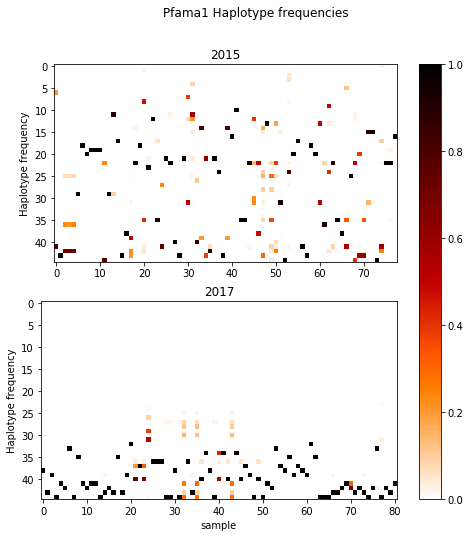

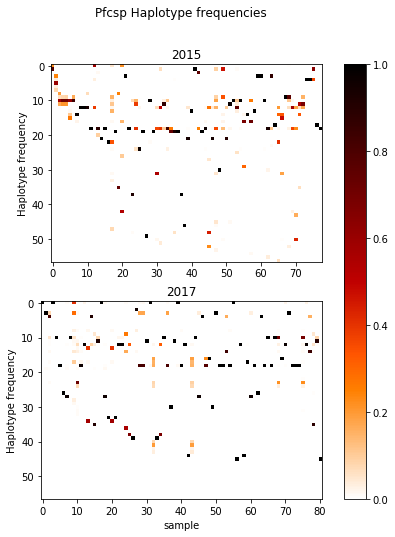

In [7]:
cmap = 'gist_heat_r'
#Pfama1
fig, axs = plt.subplots(2, 1)
fig.set_size_inches([8,8])
fig.suptitle('Pfama1 Haplotype frequencies')

images = []
images.append(axs[0].imshow(genotypes_pre_ama.T, cmap = cmap))
axs[0].set_title('2015')
axs[0].set_ylabel('Haplotype frequency')

images.append(axs[1].imshow(genotypes_post_ama.T, cmap = cmap))
axs[1].set_title('2017')
axs[1].set_xlabel('sample')
axs[1].set_ylabel('Haplotype frequency')
fig.colorbar(images[0], ax = axs)
plt.show()


#Pfcsp
fig, axs = plt.subplots(2, 1)
fig.set_size_inches([8,8])
fig.suptitle('Pfcsp Haplotype frequencies')

images = []
images.append(axs[0].imshow(genotypes_pre_csp.T, cmap = cmap))
axs[0].set_title('2015')
axs[0].set_ylabel('Haplotype frequency')

images.append(axs[1].imshow(genotypes_post_csp.T, cmap = cmap))
axs[1].set_title('2017')
axs[1].set_xlabel('sample')
axs[1].set_ylabel('Haplotype frequency')
fig.colorbar(images[0], ax = axs)
plt.show()

/Users/arnau/env/genomics/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


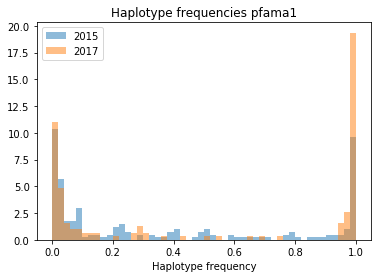

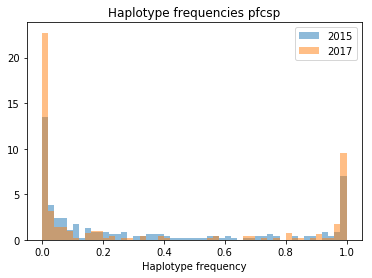

In [8]:
plt.hist(genotypes_pre_ama.flatten(), 50, range = [0.0001, 1], normed = True, alpha = .5, label = '2015')
plt.hist(genotypes_post_ama.flatten(), 50, range = [0.0001, 1], normed = True, alpha = .5, label = '2017')
plt.title('Haplotype frequencies pfama1')
plt.xlabel('Haplotype frequency')
plt.legend()
plt.show()

plt.hist(genotypes_pre_csp.flatten(), 50, range = [0.0001, 1], normed = True, alpha = .5, label = '2015')
plt.hist(genotypes_post_csp.flatten(), 50, range = [0.0001, 1], normed = True, alpha = .5, label = '2017')
plt.title('Haplotype frequencies pfcsp')
plt.xlabel('Haplotype frequency')
plt.legend()
plt.show()

To measure the similarity between samples I calculate the 50-dimensional distance of the genotype vectors (see definition and description of function dist on top of the notebook). This distance measurement give 0 when the genotype distributions are identical, and a positive value when they are different. 

In [8]:
#Pfama1
#These distance matrices show the distance between sample i and j in the matrix position (i,j)
dist_mat_pre_ama = relatedness_mat(genotypes_pre_ama, genotypes_pre_ama, method = 'L2')
dist_mat_post_ama = relatedness_mat(genotypes_post_ama, genotypes_post_ama, method = 'L2')
#dist_mat_cross = relatedness_mat(genotypes_pre, genotypes_post, method = 'L2')

l1_mat_pre_ama = relatedness_mat(genotypes_pre_ama, genotypes_pre_ama, method = 'L1')
l1_mat_post_ama = relatedness_mat(genotypes_post_ama, genotypes_post_ama, method = 'L1')
#l1_mat_cross = relatedness_mat(genotypes_pre, genotypes_post, method = 'L1')


#Pfcsp
dist_mat_pre_csp = relatedness_mat(genotypes_pre_csp, genotypes_pre_csp, method = 'L2')
dist_mat_post_csp = relatedness_mat(genotypes_post_csp, genotypes_post_csp, method = 'L2')
#dist_mat_cross = relatedness_mat(genotypes_pre, genotypes_post, method = 'L2')

l1_mat_pre_csp = relatedness_mat(genotypes_pre_csp, genotypes_pre_csp, method = 'L1')
l1_mat_post_csp = relatedness_mat(genotypes_post_csp, genotypes_post_csp, method = 'L1')
#l1_mat_cross = relatedness_mat(genotypes_pre, genotypes_post, method = 'L1')

Here I show the mean distances between pairs in pre, in post and between pre and post (cross), and below I show a histogram of the distributions of these values. 

In [9]:
def print_means(mat_pre, mat_post, text = '', diag = False):
    """This method prints the mean relatedness pre and 
    post intervention from two matrices.
    
    Parameters:
    -----------
    mat_pre: np.ndarray
        Matrix of pairwise relatedness of samples from 2015
    mat_post: np.ndarray
        Matrix of pairwise relatedness of samples from 2017
    diag: bool
        It specifies if the matrix is diagonally symmetric
        
    Returns:
    text describing the mean relatedness and the change 
    between 2015 and 2017, with the errors and power
        """
    mean_pre, err_pre = mat_mean_err(mat_pre, diag = diag)
    print("Mean 2015 "+text+": " + str(mean_pre) + " +/- " + str(err_pre))
    mean_post, err_post = mat_mean_err(mat_post, diag = diag)
    print("Mean 2017 "+text+": " + str(mean_post) + " +/- " + str(err_post))
    diff_means = mean_post - mean_pre 
    diff_err = np.sqrt(err_pre**2 + err_post**2)
    power = 1 - sig2pow(np.abs(diff_means)/diff_err)
    print ("Difference in dist between 2015 and 2017: " + str(diff_means) + "+/-" + str(diff_err) + ', p = ' + str(power))

In [10]:
#Pfama1
print_means(dist_mat_pre_ama, dist_mat_post_ama, "dist pfama1")
print("")
print_means(l1_mat_pre_ama, l1_mat_post_ama, "dist pfama1")

print("")

#Pfcsp
print_means(dist_mat_pre_csp, dist_mat_post_csp, "dist pfcsp")
print("")
print_means(l1_mat_pre_csp, l1_mat_post_csp, "dist pfcsp")

Mean 2015 dist pfama1: 1.1959511570981718 +/- 0.0
Mean 2017 dist pfama1: 1.226508876043971 +/- 0.0
Difference in dist between 2015 and 2017: 0.030557718945799284+/-0.0, p = 0.0

Mean 2015 dist pfama1: 1.8892664114066637 +/- 0.0


/Users/arnau/env/genomics/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


Mean 2017 dist pfama1: 1.8033079071899099 +/- 0.0
Difference in dist between 2015 and 2017: -0.08595850421675388+/-0.0, p = 0.0

Mean 2015 dist pfcsp: 1.146901397789216 +/- 0.0
Mean 2017 dist pfcsp: 1.2101833442411827 +/- 0.0
Difference in dist between 2015 and 2017: 0.06328194645196672+/-0.0, p = 0.0

Mean 2015 dist pfcsp: 1.8458317312042694 +/- 0.0
Mean 2017 dist pfcsp: 1.831910510648185 +/- 0.0
Difference in dist between 2015 and 2017: -0.013921220556084357+/-0.0, p = 0.0


/Users/arnau/env/genomics/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


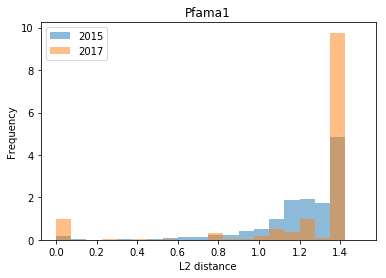

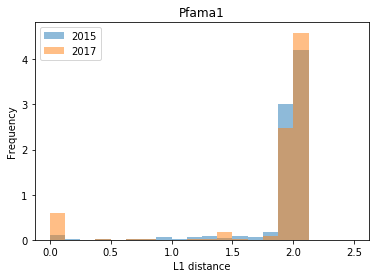

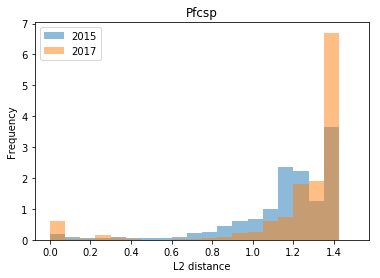

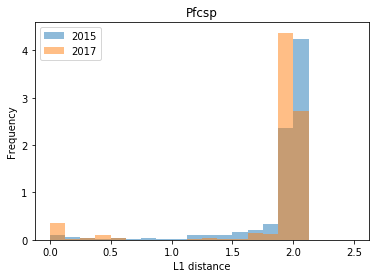

In [11]:
#Pfama1
hist_l2_ama_pre = plt.hist(mat_vals(dist_mat_pre_ama), 20, normed = True, range = [0,1.5], label = '2015', alpha = .5)
hist_l2_ama_post = plt.hist(mat_vals(dist_mat_post_ama), 20, normed = True, range = [0,1.5], label = '2017', alpha = .5)
#plt.hist(dist_mat_cross.flatten(), 20, range = [0,3], label = 'cross', alpha = .5)
plt.title('Pfama1')
plt.xlabel('L2 distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.hist(mat_vals(l1_mat_pre_ama), 20, normed = True, range = [0,2.5], label = '2015', alpha = .5)
plt.hist(mat_vals(l1_mat_post_ama), 20, normed = True, range = [0,2.5], label = '2017', alpha = .5)
#plt.hist(l1_mat_cross.flatten(), 20, range = [0,10], label = 'cross', alpha = .5)
plt.title('Pfama1')
plt.xlabel('L1 distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Pfcsp
hist_l2_csp_pre = plt.hist(mat_vals(dist_mat_pre_csp), 20, normed = True, range = [0,1.5], label = '2015', alpha = .5)
hist_l2_csp_post = plt.hist(mat_vals(dist_mat_post_csp), 20, normed = True, range = [0,1.5], label = '2017', alpha = .5)
#plt.hist(dist_mat_cross.flatten(), 20, range = [0,3], label = 'cross', alpha = .5)
plt.title('Pfcsp')
plt.xlabel('L2 distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.hist(mat_vals(l1_mat_pre_csp), 20, normed = True, range = [0,2.5], label = '2015', alpha = .5)
plt.hist(mat_vals(l1_mat_post_csp), 20, normed = True, range = [0,2.5], label = '2017', alpha = .5)
#plt.hist(l1_mat_cross.flatten(), 20, range = [0,10], label = 'cross', alpha = .5)
plt.title('Pfcsp')
plt.xlabel('L1 distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

We see that, as expected, the mean distances in pre are larger than in post, since the correlation simulated for the post data is stronger. Also, the distances between post and pre (cross) are the largest since these distances are the least correlated and the largest (pre cases are located aroung the 25th genotype while post are around the 15th.)

Finally, here I show the distance matrices for pre, post and cross where we can see the distances for each of the pair comparisons. 

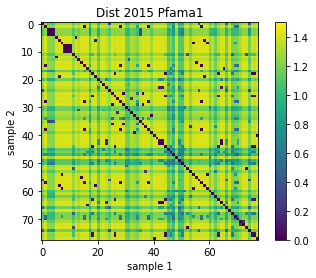

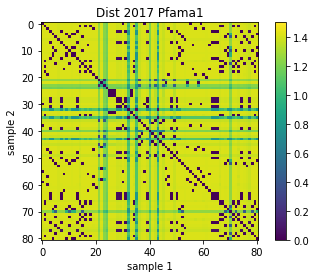

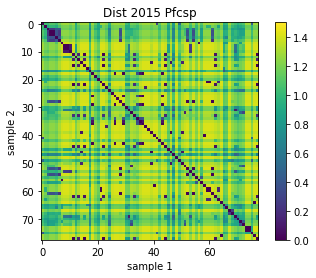

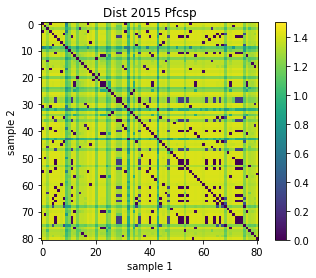

In [13]:
cmap = 'viridis'

plt.imshow(dist_mat_pre_ama, vmin = 0, vmax = 1.5, cmap = cmap)
plt.title('Dist 2015 Pfama1')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.colorbar()
plt.show()

plt.imshow(dist_mat_post_ama, vmin = 0, vmax = 1.5, cmap = cmap)
plt.title('Dist 2017 Pfama1')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.colorbar()
plt.show()

plt.imshow(dist_mat_pre_csp, vmin = 0, vmax = 1.5, cmap = cmap)
plt.title('Dist 2015 Pfcsp')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.colorbar()
plt.show()

plt.imshow(dist_mat_post_csp, vmin = 0, vmax = 1.5, cmap = cmap)
plt.title('Dist 2015 Pfcsp')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.colorbar()
plt.show()



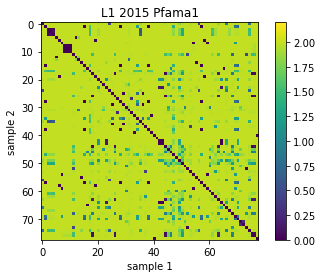

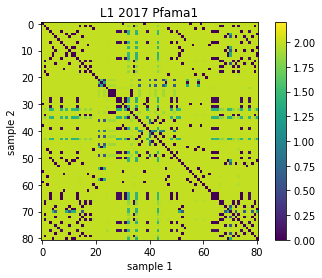

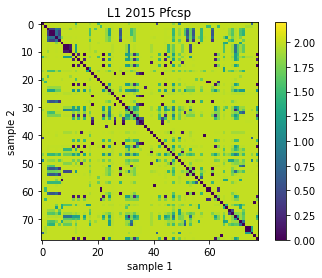

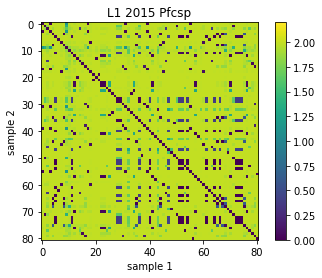

In [14]:
cmap = 'viridis'

plt.imshow(l1_mat_pre_ama, vmin = 0, vmax = 2.2, cmap = cmap)
plt.title('L1 2015 Pfama1')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.colorbar()
plt.show()

plt.imshow(l1_mat_post_ama, vmin = 0, vmax = 2.2, cmap = cmap)
plt.title('L1 2017 Pfama1')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.colorbar()
plt.show()

plt.imshow(l1_mat_pre_csp, vmin = 0, vmax = 2.2, cmap = cmap)
plt.title('L1 2015 Pfcsp')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.colorbar()
plt.show()

plt.imshow(l1_mat_post_csp, vmin = 0, vmax = 2.2, cmap = cmap)
plt.title('L1 2015 Pfcsp')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.colorbar()
plt.show()



In [12]:
#Pfama1
jacc_mat_pre_ama = relatedness_mat(genotypes_pre_ama,genotypes_pre_ama, method = 'jaccard')
jacc_mat_post_ama = relatedness_mat(genotypes_post_ama,genotypes_post_ama, method = 'jaccard')

bin_mat_pre_ama = relatedness_mat(genotypes_pre_ama,genotypes_pre_ama, method = 'bin_sharing')
bin_mat_post_ama = relatedness_mat(genotypes_post_ama,genotypes_post_ama, method = 'bin_sharing')

#Pfcsp
jacc_mat_pre_csp = relatedness_mat(genotypes_pre_csp,genotypes_pre_csp, method = 'jaccard')
jacc_mat_post_csp = relatedness_mat(genotypes_post_csp,genotypes_post_csp, method = 'jaccard')

bin_mat_pre_csp = relatedness_mat(genotypes_pre_csp,genotypes_pre_csp, method = 'bin_sharing')
bin_mat_post_csp = relatedness_mat(genotypes_post_csp,genotypes_post_csp, method = 'bin_sharing')


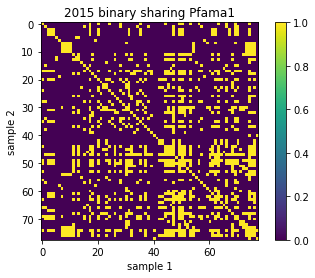

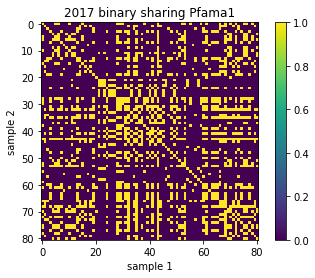

Mean 2015 binary sharing Pfama1: 0.21203155818540434 +/- 0.0
Mean 2017 binary sharing Pfama1: 0.25041914342325866 +/- 0.0
Difference in dist between 2015 and 2017: 0.03838758523785432+/-0.0, p = 0.0


/Users/arnau/env/genomics/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


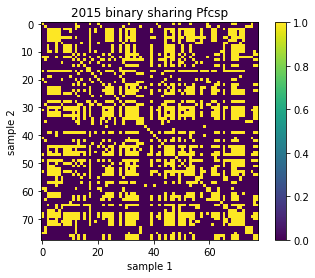

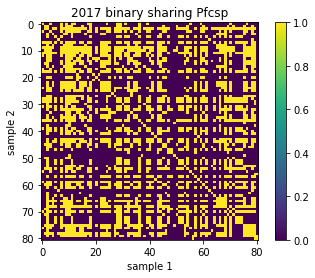

Mean 2015 binary sharing Pfcsp: 0.3247863247863248 +/- 0.0
Mean 2017 binary sharing Pfcsp: 0.36777930193568054 +/- 0.0
Difference in dist between 2015 and 2017: 0.04299297714935574+/-0.0, p = 0.0


In [13]:
plt.imshow(bin_mat_pre_ama, vmin = 0, vmax = 1)
plt.colorbar()
plt.title('2015 binary sharing Pfama1')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.show()

plt.imshow(bin_mat_post_ama, vmin = 0, vmax = 1)
plt.colorbar()
plt.title('2017 binary sharing Pfama1')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.show()

print_means(bin_mat_pre_ama, bin_mat_post_ama, 'binary sharing Pfama1')

plt.imshow(bin_mat_pre_csp, vmin = 0, vmax = 1)
plt.colorbar()
plt.title('2015 binary sharing Pfcsp')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.show()

plt.imshow(bin_mat_post_csp, vmin = 0, vmax = 1)
plt.colorbar()
plt.title('2017 binary sharing Pfcsp')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.show()

print_means(bin_mat_pre_csp, bin_mat_post_csp, 'binary sharing Pfcsp')

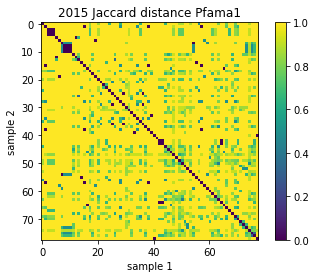

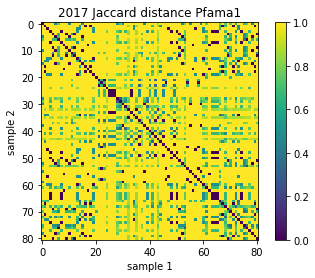

Mean 2015 Jaccard distance Pfama1: 0.9364351852764082 +/- 0.0
Mean 2017 Jaccard distance Pfama1: 0.8895005754630811 +/- 0.0
Difference in dist between 2015 and 2017: -0.04693460981332709+/-0.0, p = 0.0


/Users/arnau/env/genomics/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


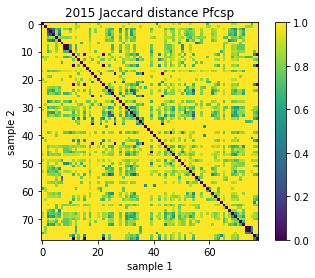

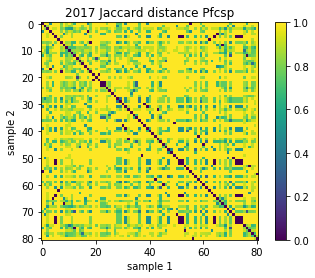

Mean 2015 Jaccard distance Pfcsp: 0.9132026822543413 +/- 0.0
Mean 2017 Jaccard distance Pfcsp: 0.8967375261556259 +/- 0.0
Difference in dist between 2015 and 2017: -0.01646515609871546+/-0.0, p = 0.0


In [17]:
plt.imshow(jacc_mat_pre_ama, vmin = 0, vmax = 1)
plt.colorbar()
plt.title('2015 Jaccard distance Pfama1')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.show()

plt.imshow(jacc_mat_post_ama, vmin = 0, vmax = 1)
plt.colorbar()
plt.title('2017 Jaccard distance Pfama1')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.show()

print_means(jacc_mat_pre_ama, jacc_mat_post_ama, 'Jaccard distance Pfama1')

plt.imshow(jacc_mat_pre_csp, vmin = 0, vmax = 1)
plt.colorbar()
plt.title('2015 Jaccard distance Pfcsp')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.show()

plt.imshow(jacc_mat_post_csp, vmin = 0, vmax = 1)
plt.colorbar()
plt.title('2017 Jaccard distance Pfcsp')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.show()

print_means(jacc_mat_pre_csp, jacc_mat_post_csp, 'Jaccard distance Pfcsp')

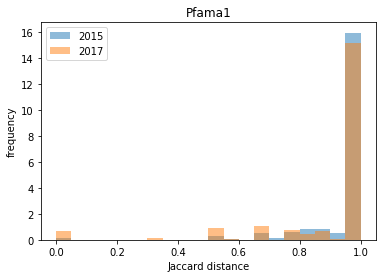

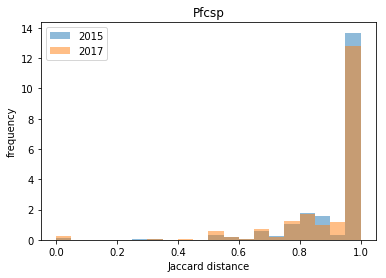

In [18]:
hist_jacc_ama_pre = plt.hist(mat_vals(jacc_mat_pre_ama), 20, normed = True, range = [0,1], label = '2015', alpha = .5)
hist_jacc_ama_post = plt.hist(mat_vals(jacc_mat_post_ama), 20, normed = True, range = [0,1], label = '2017', alpha = .5)
#plt.hist(dist_mat_cross.flatten(), 20, range = [0,3], label = 'cross', alpha = .5)
plt.xlabel('Jaccard distance')
plt.title('Pfama1')
plt.ylabel('frequency')
plt.legend()
plt.show()

hist_jacc_csp_pre = plt.hist(mat_vals(jacc_mat_pre_csp), 20, normed = True, range = [0,1], label = '2015', alpha = .5)
hist_jacc_csp_post = plt.hist(mat_vals(jacc_mat_post_csp), 20, normed = True, range = [0,1], label = '2017', alpha = .5)
#plt.hist(dist_mat_cross.flatten(), 20, range = [0,3], label = 'cross', alpha = .5)
plt.xlabel('Jaccard distance')
plt.title('Pfcsp')
plt.ylabel('frequency')
plt.legend()
plt.show()


In [14]:
#Pfama1
pcor_mat_pre_ama = relatedness_mat(genotypes_pre_ama,genotypes_pre_ama, method = 'pcorr')
pcor_mat_post_ama = relatedness_mat(genotypes_post_ama,genotypes_post_ama, method = 'pcorr')

#Pfcsp
pcor_mat_pre_csp = relatedness_mat(genotypes_pre_csp,genotypes_pre_csp, method = 'pcorr')
pcor_mat_post_csp = relatedness_mat(genotypes_post_csp,genotypes_post_csp, method = 'pcorr')


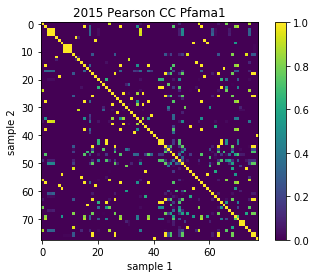

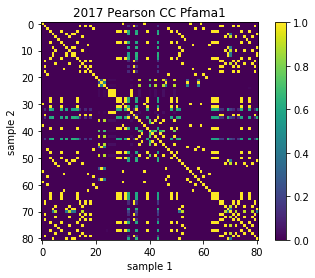

Mean 2015 Pearson CC Pfama1: 0.03566825817963601 +/- 0.0
Mean 2017 Pearson CC Pfama1: 0.08537039279133904 +/- 0.0
Difference in dist between 2015 and 2017: 0.04970213461170303+/-0.0, p = 0.0


/Users/arnau/env/genomics/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


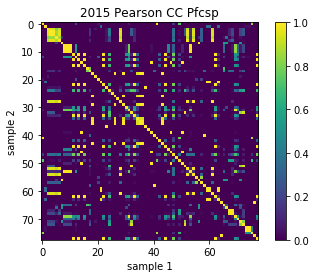

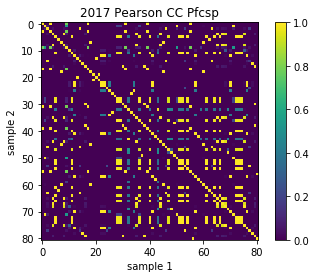

Mean 2015 Pearson CC Pfcsp: 0.06664108995660878 +/- 0.0
Mean 2017 Pearson CC Pfcsp: 0.07159090952214987 +/- 0.0
Difference in dist between 2015 and 2017: 0.004949819565541094+/-0.0, p = 0.0


In [20]:
#Pfama1
plt.imshow(pcor_mat_pre_ama, vmin = 0, vmax = 1)
plt.colorbar()
plt.title('2015 Pearson CC Pfama1')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.show()

plt.imshow(pcor_mat_post_ama, vmin = 0, vmax = 1)
plt.colorbar()
plt.title('2017 Pearson CC Pfama1')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.show()

print_means(pcor_mat_pre_ama, pcor_mat_post_ama, 'Pearson CC Pfama1')

#Pfcsp
plt.imshow(pcor_mat_pre_csp, vmin = 0, vmax = 1)
plt.colorbar()
plt.title('2015 Pearson CC Pfcsp')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.show()

plt.imshow(pcor_mat_post_csp, vmin = 0, vmax = 1)
plt.colorbar()
plt.title('2017 Pearson CC Pfcsp')
plt.xlabel('sample 1')
plt.ylabel('sample 2')
plt.show()


print_means(pcor_mat_pre_csp, pcor_mat_post_csp, 'Pearson CC Pfcsp')

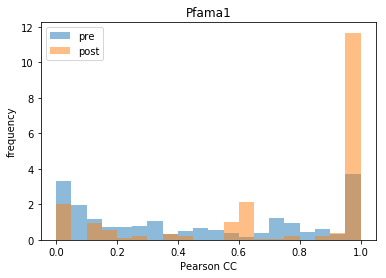

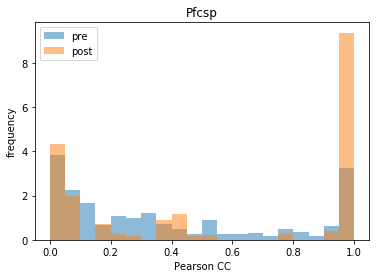

In [21]:
hist_pcor_ama_pre = plt.hist(mat_vals(pcor_mat_pre_ama), 20, normed = True, range = [0,1], label = 'pre', alpha = .5)
hist_pcor_ama_post = plt.hist(mat_vals(pcor_mat_post_ama), 20, normed = True, range = [0,1], label = 'post', alpha = .5)
plt.xlabel('Pearson CC')
plt.title('Pfama1')
plt.ylabel('frequency')
plt.legend()
plt.show()

hist_pcor_csp_pre = plt.hist(mat_vals(pcor_mat_pre_csp), 20, normed = True, range = [0,1], label = 'pre', alpha = .5)
hist_pcor_csp_post = plt.hist(mat_vals(pcor_mat_post_csp), 20, normed = True, range = [0,1], label = 'post', alpha = .5)
plt.xlabel('Pearson CC')
plt.title('Pfcsp')
plt.ylabel('frequency')
plt.legend()
plt.show()


In [15]:
data_hist = {
    'bins_L2_ama_pre': hist_l2_ama_pre[0],
    'bins_L2_ama_post': hist_l2_ama_post[0],
    'bins_L2_csp_pre': hist_l2_csp_pre[0],
    'bins_L2_csp_post': hist_l2_csp_post[0],
    'bins_JD_ama_pre': hist_jacc_ama_pre[0],
    'bins_JD_ama_post': hist_jacc_ama_post[0],
    'bins_JD_csp_pre': hist_jacc_csp_pre[0],
    'bins_JD_csp_post': hist_jacc_csp_post[0],
    'bins_pcor_ama_pre': hist_pcor_ama_pre[0],
    'bins_pcor_ama_post': hist_pcor_ama_post[0],
    'bins_pcor_csp_pre': hist_pcor_csp_pre[0],
    'bins_pcor_csp_post': hist_pcor_csp_post[0],
}
data_bins = {
    'hist_L2_ama_pre': hist_l2_ama_pre[1],
    'hist_L2_ama_post': hist_l2_ama_post[1],
    'hist_L2_csp_pre': hist_l2_csp_pre[1],
    'hist_L2_csp_post': hist_l2_csp_post[1],
    'hist_JD_ama_pre': hist_jacc_ama_pre[1],
    'hist_JD_ama_post': hist_jacc_ama_post[1],
    'hist_JD_csp_pre': hist_jacc_csp_pre[1],
    'hist_JD_csp_post': hist_jacc_csp_post[1],
    'hist_pcor_ama_pre': hist_pcor_ama_pre[1],
    'hist_pcor_ama_post': hist_pcor_ama_post[1],
    'hist_pcor_csp_pre': hist_pcor_csp_pre[1],
    'hist_pcor_csp_post': hist_pcor_csp_post[1],
}

NameError: name 'hist_jacc_ama_pre' is not defined

In [26]:
df_bins = pd.DataFrame(data=data_bins)
df_hist = pd.DataFrame(data=data_hist)

In [27]:
df_bins.to_csv('/Users/arnau/Documents/isglobal/genomics/notes/genomics/haplotypes_magude_2015_2017/histogram_bins.csv')
df_hist.to_csv('/Users/arnau/Documents/isglobal/genomics/notes/genomics/haplotypes_magude_2015_2017/histogram_data.csv')

# Fraction of extremely similar pairs 

### TODO:

- for all metrics, error bars and power in change

In [16]:
def get_percent(mat, p, mask = None, diag = True):
    """This method returns the percentile value for all
    the values within a matrix.
    
    Parameters:
    -----------
    mat: np.ndarray
        Matrix of values.
    p: float
        It defines the percentile to obtain 
    mask: np.array
        Mask selecting the elements in mat used.
    diag: bool
        It specifies whether the matrix is diagonally
        symmetric and repeated cases are excluded

    Returns:
    --------
    val: float
        value corresponding to the percentile
    """
    return np.percentile(mat_vals(mat, mask = mask, diag = diag), p)

def percentile_change(mat_pre, mat_post, p, mask = None, diag = True, inverse = False):
    """
    This method measures the change in proportion of populaiton
    within a precentile defined on the first population. 
    
    Parameters:
    -----------
    mat_pre: np.ndarray
        Matrix of values of the first population
    mat_post: np.ndarray
        Matrix of values of the second population
    p: float
        It defines the percentile to obtain from the first population.
    mask: np.array
        Mask selecting the elements in mat used
    diag: bool
        It specifies whether the matrix is diagonally
        symmetric and repeated cases are excluded
    inverse: bool
        If True, the fractions are obtained from values below the percentile.

    Returns:
    --------
    pval: float
        Value corresponding to the percentile in mat_pre
    frac_pre: float
        Fraction of values > pval on mat_pre
    frac_post: float
        Fraction of values > pval on mat_post
    """
    pval = get_percent(mat_pre, p)
    print("Value corresponding to the "+str(p)+" percentile on the first population: " +str(pval))
    #fraction of values higher than pval for first population
    if inverse:
        frac_pre = np.sum(mat_vals(mat_pre) < pval)/float(mat_vals(mat_pre).shape[0])
    else:
        frac_pre = np.sum(mat_vals(mat_pre) > pval)/float(mat_vals(mat_pre).shape[0])
    print("Fraction of values inside this range for the second population: " + str(frac_pre))
    #fraction of values higher than pval for second population
    if inverse:
        frac_post = np.sum(mat_vals(mat_post) < pval)/float(mat_vals(mat_post).shape[0])
    else:
        frac_post = np.sum(mat_vals(mat_post) > pval)/float(mat_vals(mat_post).shape[0])
    print("Fraction of values inside this range for the second population: " + str(frac_post))
    return pval, frac_pre, frac_post

In [17]:
print("Distance L2 pfama1")
percentile_change(dist_mat_pre_ama, dist_mat_post_ama, 1, inverse = True)
print("Distance L2 pfcsp")
percentile_change(dist_mat_pre_csp, dist_mat_post_csp, 1, inverse = True)

print("")
print("Distance L1 pfama1")
percentile_change(l1_mat_pre_ama, l1_mat_post_ama, 1, inverse = True)
print("Distance L1 pfcsp")
percentile_change(l1_mat_pre_csp, l1_mat_post_csp, 1, inverse = True)

print("")
print("Jaccard distance pfama1")
percentile_change(jacc_mat_pre_ama, jacc_mat_post_ama, 1, inverse = True)
print("Jaccard distance pfcsp")
percentile_change(jacc_mat_pre_csp, jacc_mat_post_csp, 1, inverse = True)

print("")
print("Pearson CC pfama1")
percentile_change(pcor_mat_pre_ama, pcor_mat_post_ama, 99)
print("Pearson CC pfcsp")
percentile_change(pcor_mat_pre_csp, pcor_mat_post_csp, 99)

Distance L2 pfama1
Value corresponding to the 1 percentile on the first population: 0.016399713702063338
Fraction of values inside this range for the second population: 0.010323010323010324
Fraction of values inside this range for the second population: 0.04969135802469136
Distance L2 pfcsp
Value corresponding to the 1 percentile on the first population: 0.018751026761601876
Fraction of values inside this range for the second population: 0.010323010323010324
Fraction of values inside this range for the second population: 0.033950617283950615

Distance L1 pfama1
Value corresponding to the 1 percentile on the first population: 0.023253517721301024
Fraction of values inside this range for the second population: 0.010323010323010324
Fraction of values inside this range for the second population: 0.04969135802469136
Distance L1 pfcsp
Value corresponding to the 1 percentile on the first population: 0.030991576573386963
Fraction of values inside this range for the second population: 0.0103230

(0.9998997098567549, 0.010323010323010324, 0.033950617283950615)

# Correlations between relatedness and other properties from data 

### TODO:

- Get mean relatedness for different populations in 
    - gender
    - area
    - fevertemp
    - antimal
    - age_cat
    - den_cat
    - area2


In [18]:
#Setting transposed haplotype data with the right index dtype 
data_amaT = data_ama.T
data_amaT.index = data_amaT.index.astype(str)
data_cspT = data_csp.T
data_cspT.index = data_cspT.index.astype(str)

#Merge haplotype data with other data
merged_ama = pd.merge(data_amaT, data, left_index = True, right_index = True)
merged_csp = pd.merge(data_cspT, data, left_index = True, right_index = True)

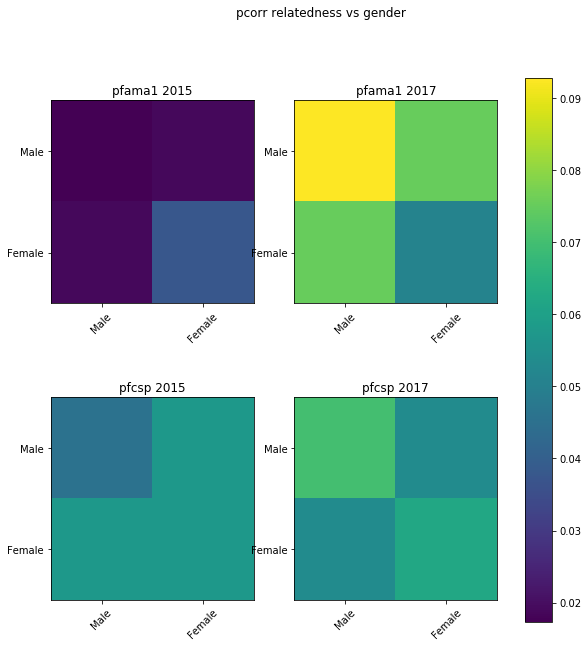

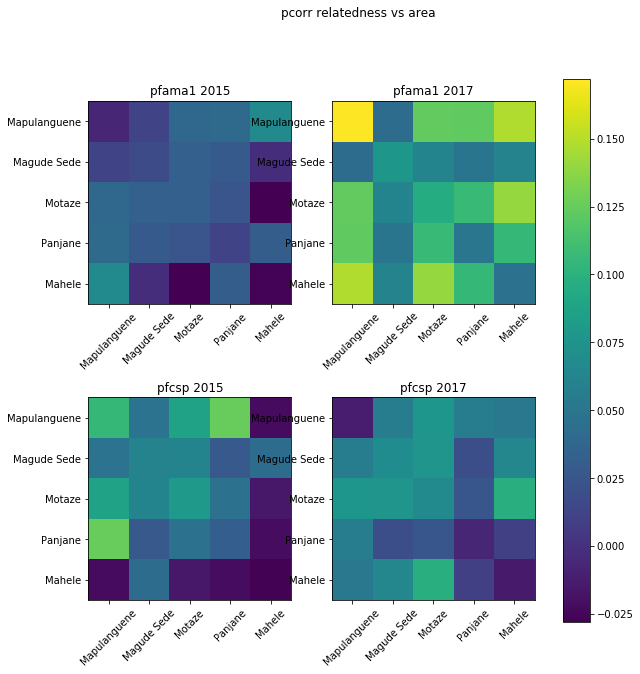

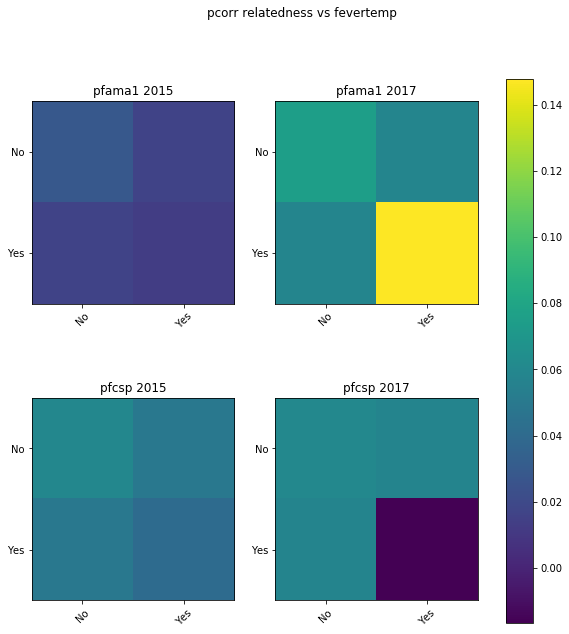

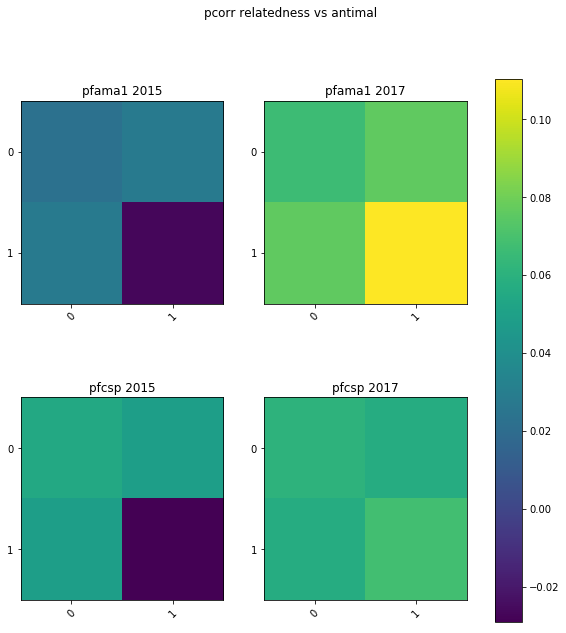

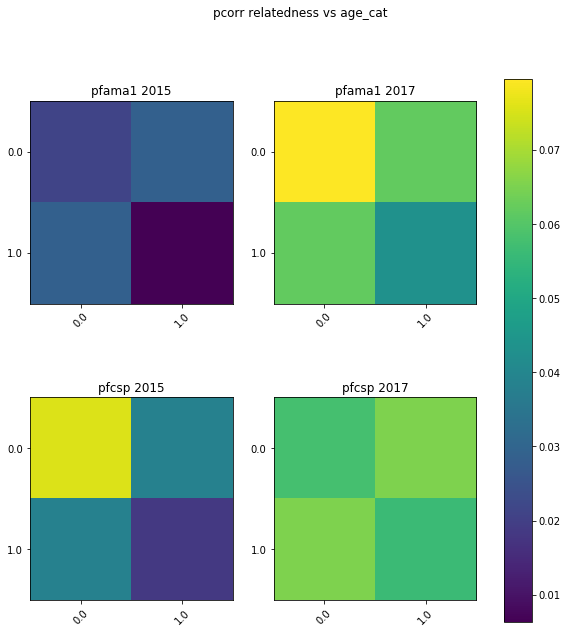

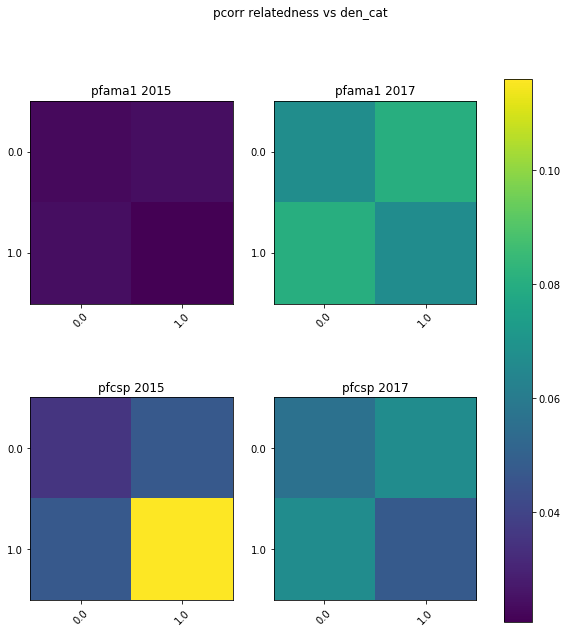

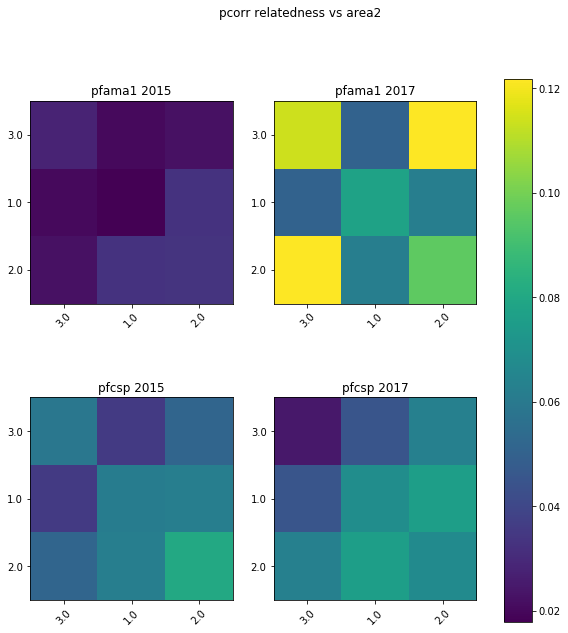

In [32]:
#Get haplotype frequencies from a selection
for category in ['gender', 'area', 'fevertemp', 'antimal', 'age_cat', 'den_cat', 'area2']: 
    types = data[category].unique()
    #list of all haplotype frequencies selected for each type
    haplotype_freqs_ama_pre = []
    haplotype_freqs_ama_post = []
    haplotype_freqs_csp_pre = []
    haplotype_freqs_csp_post = []
    for tt in types:
        hap_freq = np.array([merged_ama.loc[str(col)][:n_ama_haplotypes] for col in cols_pre if merged_ama.loc[str(col)][category] == tt], dtype = float)
        haplotype_freqs_ama_pre.append(hap_freq)
        hap_freq = np.array([merged_ama.loc[str(col)][:n_ama_haplotypes] for col in cols_post if merged_ama.loc[str(col)][category] == tt], dtype = float)
        haplotype_freqs_ama_post.append(hap_freq)
        hap_freq = np.array([merged_csp.loc[str(col)][:n_csp_haplotypes] for col in cols_pre if merged_csp.loc[str(col)][category] == tt], dtype = float)
        haplotype_freqs_csp_pre.append(hap_freq)
        hap_freq = np.array([merged_csp.loc[str(col)][:n_csp_haplotypes] for col in cols_post if merged_csp.loc[str(col)][category] == tt], dtype = float)
        haplotype_freqs_csp_post.append(hap_freq)
    
    #Get relatedness matrices for all metrics
    for mm in ['pcorr']:
        relat_cross_ama_pre = np.zeros((len(types), len(types)))
        relat_cross_ama_post = np.zeros((len(types), len(types)))
        relat_cross_csp_pre = np.zeros((len(types), len(types)))
        relat_cross_csp_post = np.zeros((len(types), len(types)))
        for ii, tt in enumerate(types):
            for jj, tt in enumerate(types):
                if jj == ii:
                    diag = True
                else:
                    diag = False
                #pfama1
                mat_ama_pre = relatedness_mat(haplotype_freqs_ama_pre[ii], haplotype_freqs_ama_pre[jj], method = mm)
                mat_ama_post = relatedness_mat(haplotype_freqs_ama_post[ii], haplotype_freqs_ama_post[jj], method = mm)
                relat_cross_ama_pre[ii,jj] = np.mean(mat_vals(mat_ama_pre, diag = diag))
                relat_cross_ama_post[ii,jj] = np.mean(mat_vals(mat_ama_post, diag = diag))
                #pfcsp
                mat_csp_pre = relatedness_mat(haplotype_freqs_csp_pre[ii], haplotype_freqs_csp_pre[jj], method = mm)
                mat_csp_post = relatedness_mat(haplotype_freqs_csp_post[ii], haplotype_freqs_csp_post[jj], method = mm)
                relat_cross_csp_pre[ii,jj] = np.mean(mat_vals(mat_csp_pre, diag = diag))
                relat_cross_csp_post[ii,jj] = np.mean(mat_vals(mat_csp_post, diag = diag))
                
        #Plot mean statistics between all them
        all_vals = np.concatenate((relat_cross_ama_pre, relat_cross_ama_post,relat_cross_csp_pre, relat_cross_csp_post))
        min_v = np.min(all_vals)
        max_v = np.max(all_vals)
        
        fig, axs = plt.subplots(2, 2)
        fig.set_size_inches([10,10])
        fig.suptitle(mm + ' relatedness vs ' + category)
            
        images = []
            
        images.append(axs[0,0].imshow(relat_cross_ama_pre, vmin = min_v, vmax = max_v))
        axs[0,0].set_title('pfama1 2015')
        axs[0,0].set_xticks(np.arange(len(types)))
        axs[0,0].set_xticklabels(types, rotation=45)
        axs[0,0].set_yticks(np.arange(len(types)))
        axs[0,0].set_yticklabels(types)
                
        images.append(axs[0,1].imshow(relat_cross_ama_post, vmin = min_v, vmax = max_v))
        axs[0,1].set_title('pfama1 2017')
        axs[0,1].set_xticks(np.arange(len(types)))
        axs[0,1].set_xticklabels(types, rotation=45)
        axs[0,1].set_yticks(np.arange(len(types)))
        axs[0,1].set_yticklabels(types)
                
        images.append(axs[1,0].imshow(relat_cross_csp_pre, vmin = min_v, vmax = max_v))
        axs[1,0].set_title('pfcsp 2015')
        axs[1,0].set_xticks(np.arange(len(types)))
        axs[1,0].set_xticklabels(types, rotation=45)
        axs[1,0].set_yticks(np.arange(len(types)))
        axs[1,0].set_yticklabels(types)
                
        images.append(axs[1,1].imshow(relat_cross_csp_post, vmin = min_v, vmax = max_v))
        axs[1,1].set_title('pfcsp 2017')
        axs[1,1].set_xticks(np.arange(len(types)))
        axs[1,1].set_xticklabels(types, rotation=45)
        axs[1,1].set_yticks(np.arange(len(types)))
        axs[1,1].set_yticklabels(types)
        
        fig.colorbar(images[3], ax = axs)
        plt.show()


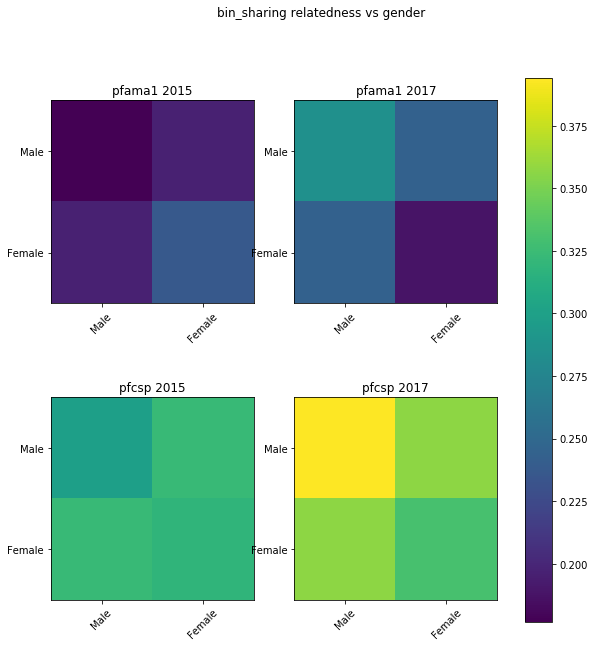

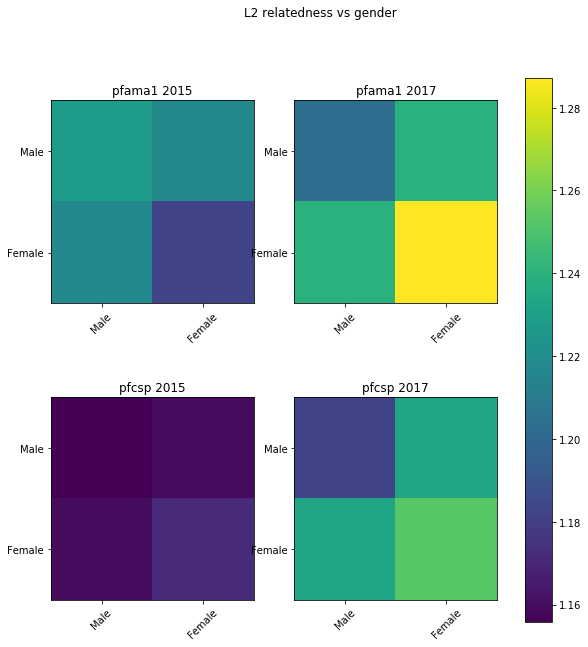

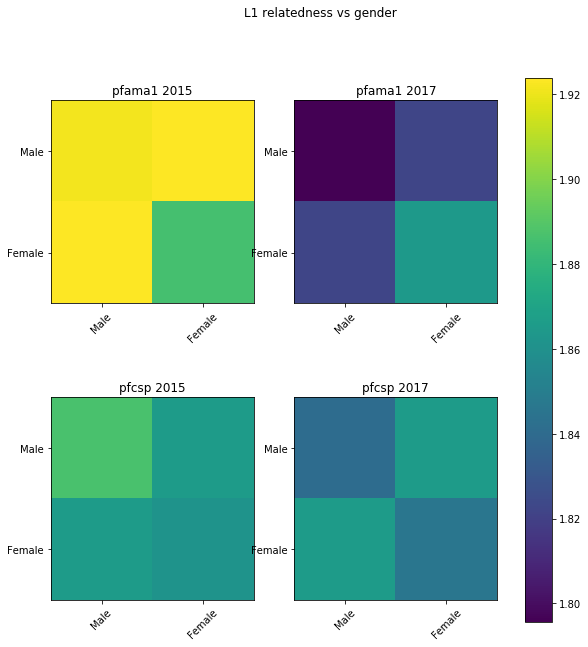

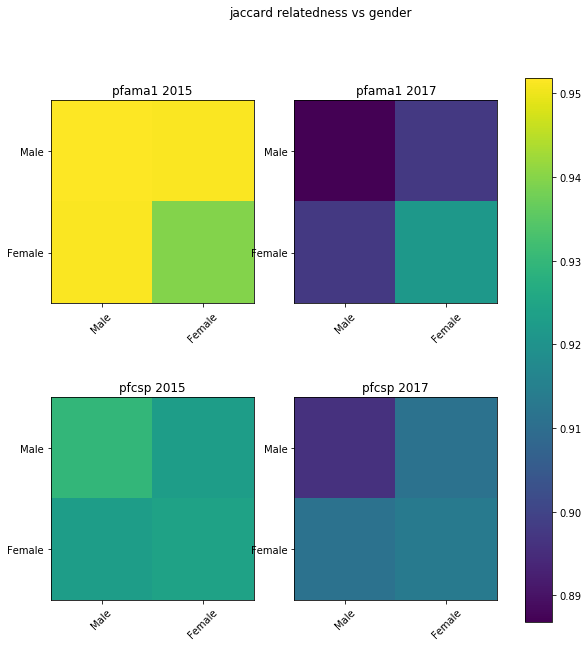

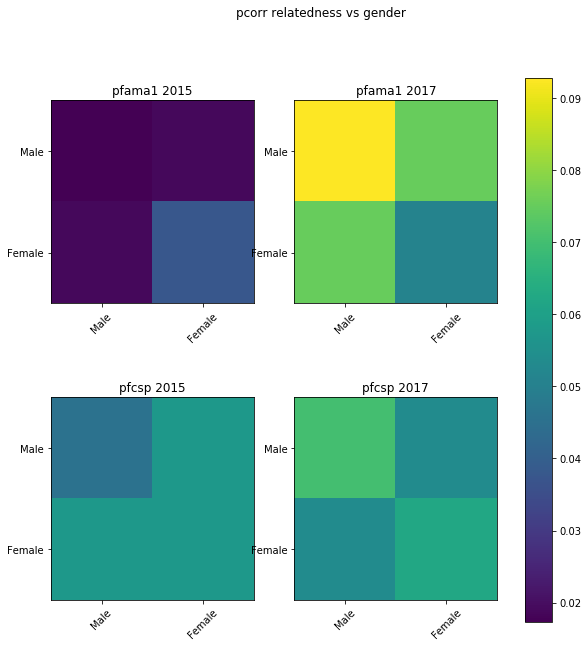

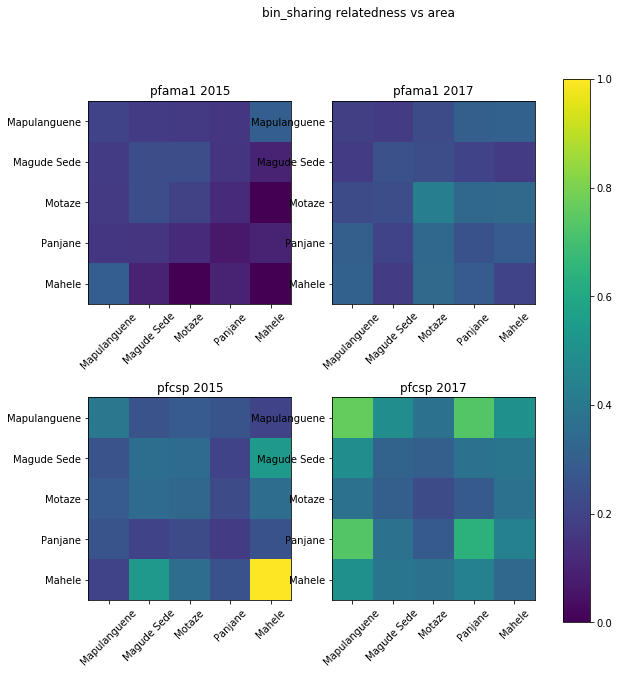

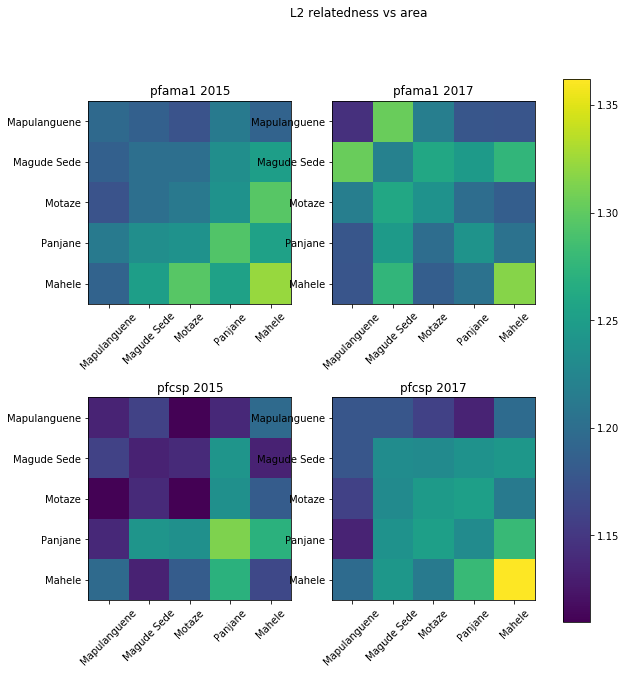

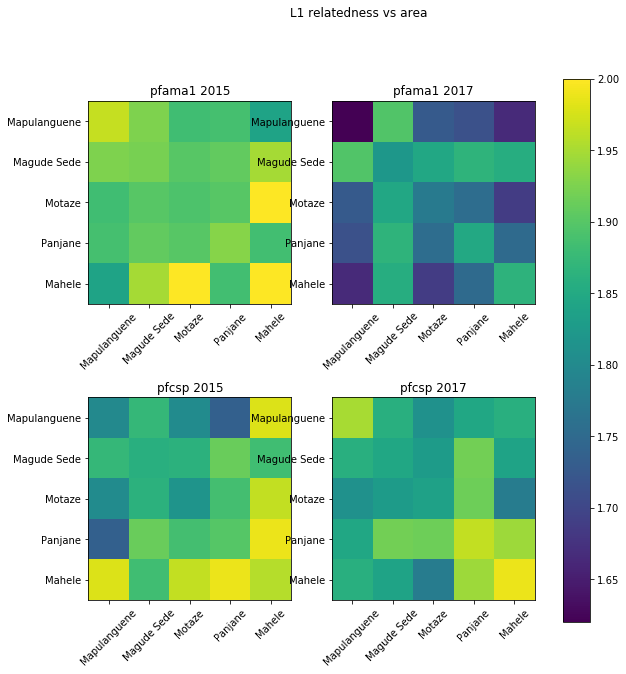

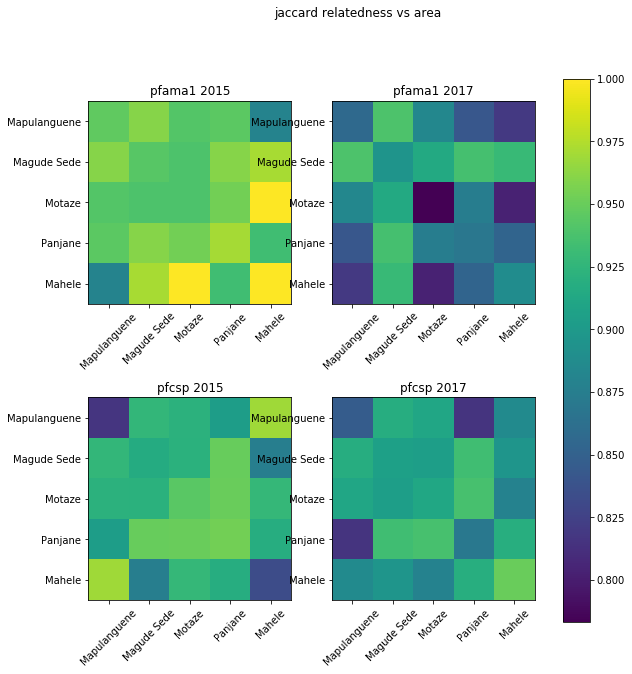

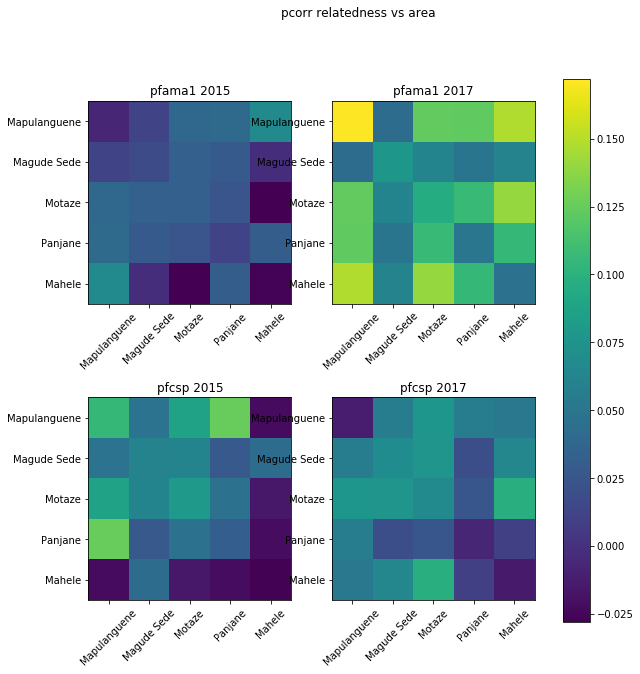

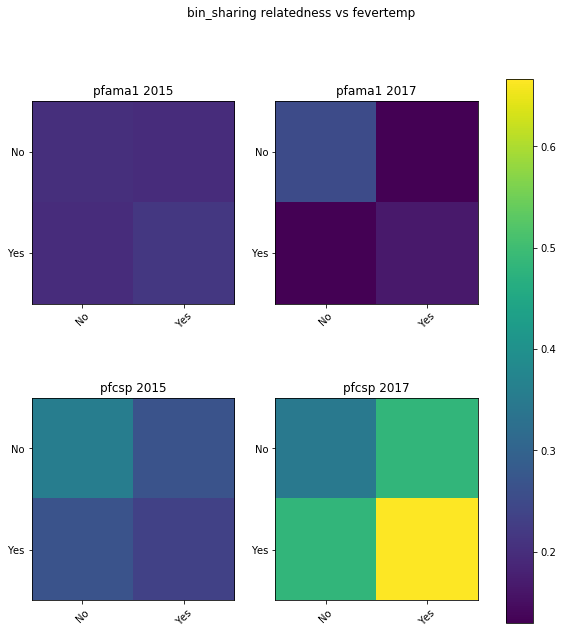

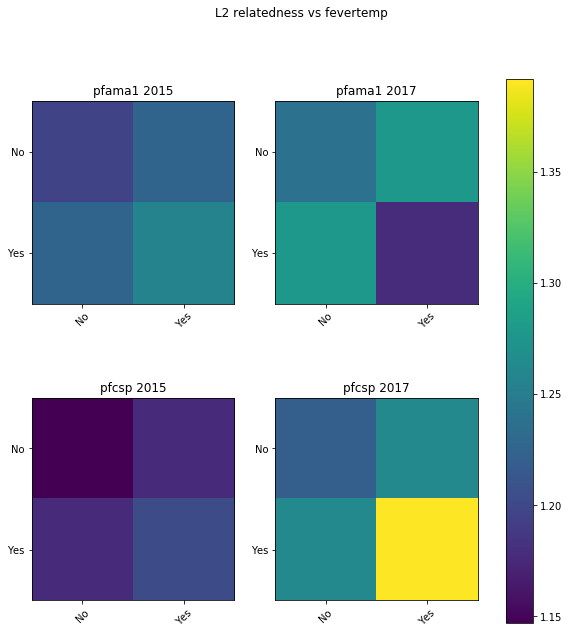

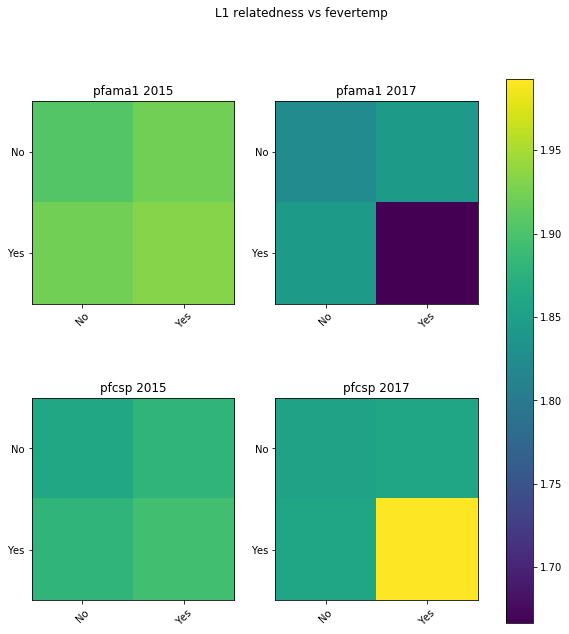

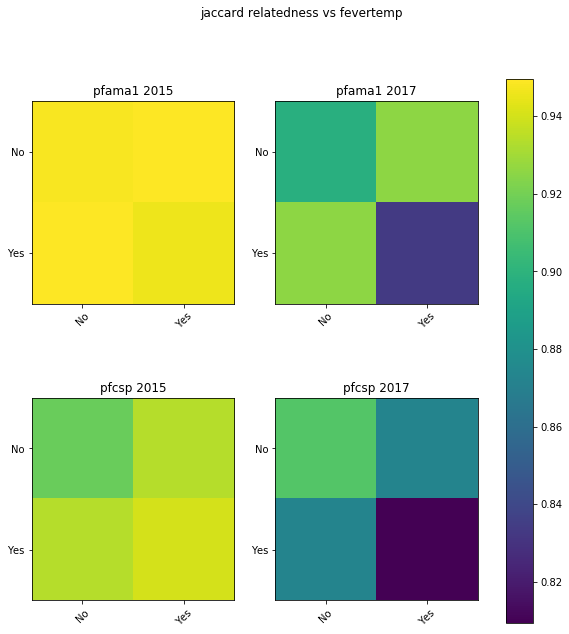

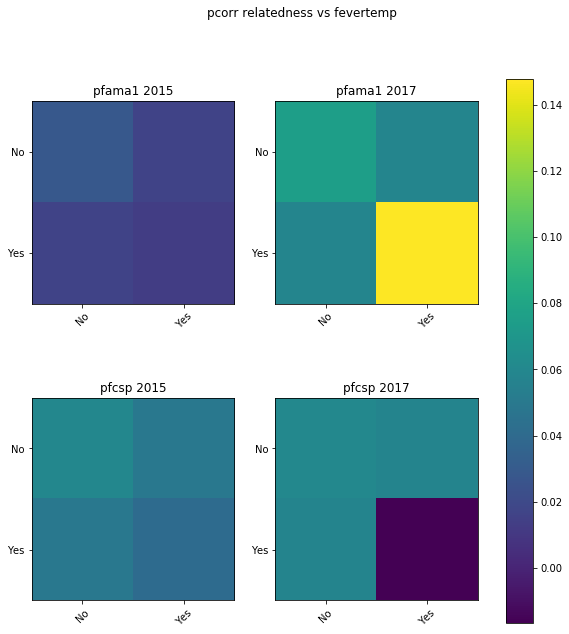

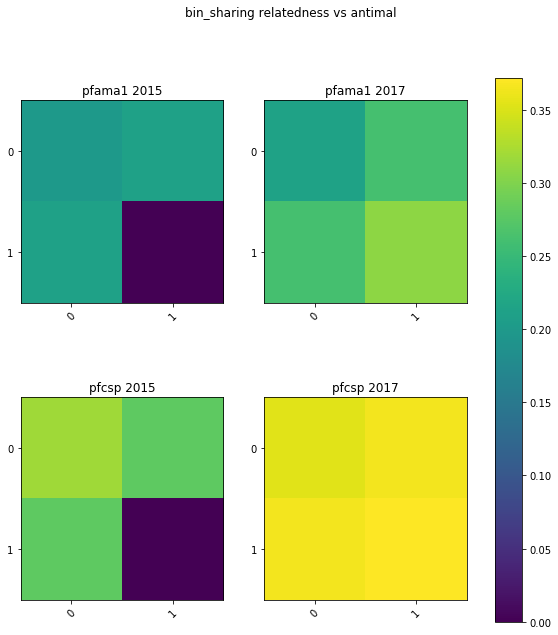

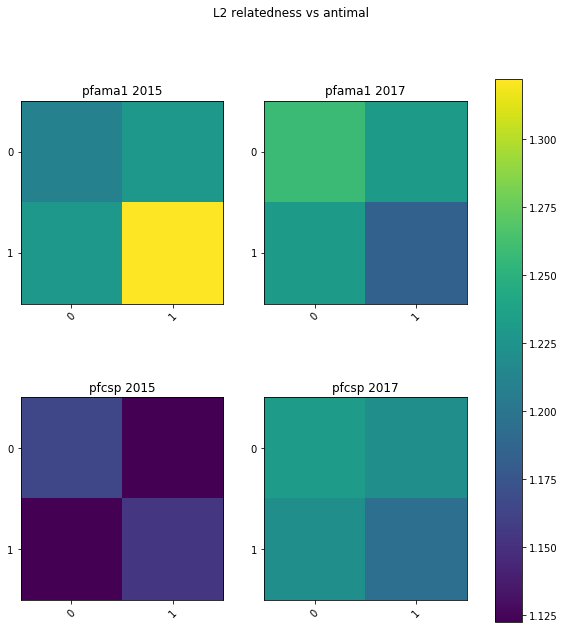

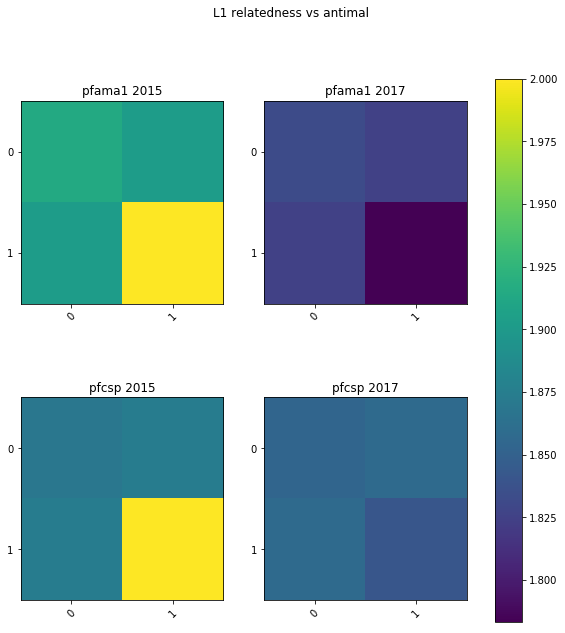

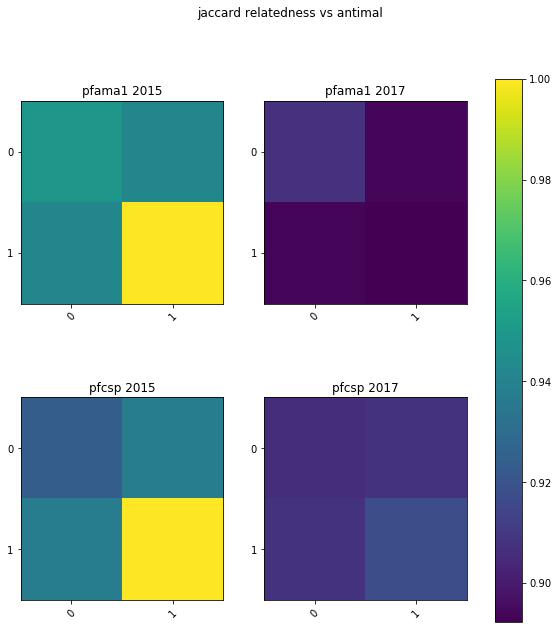

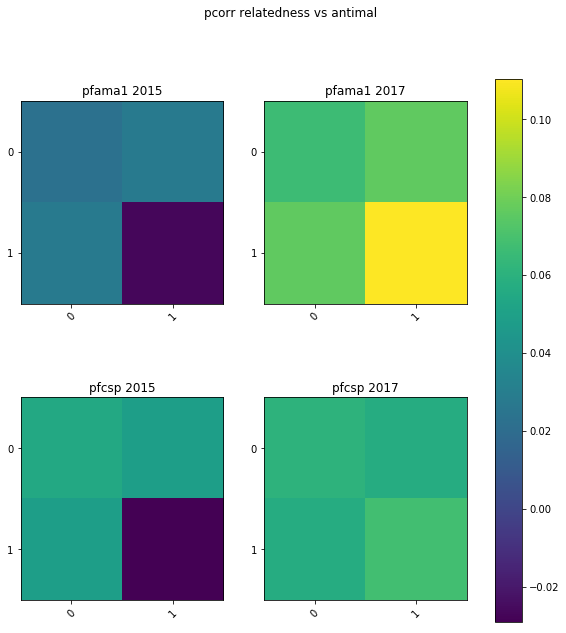

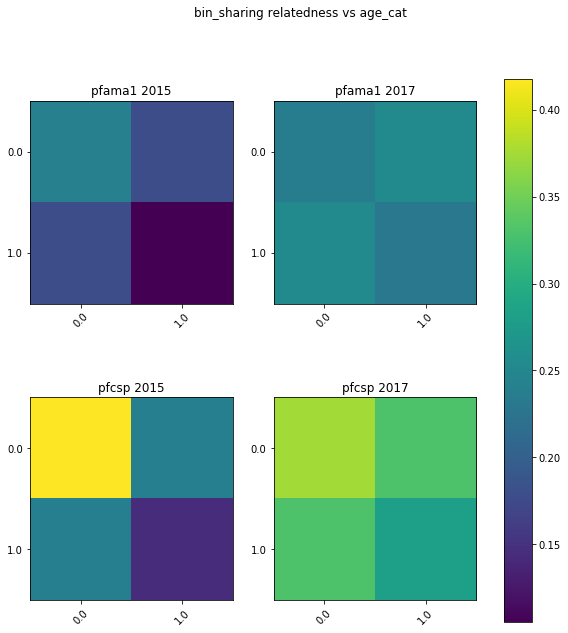

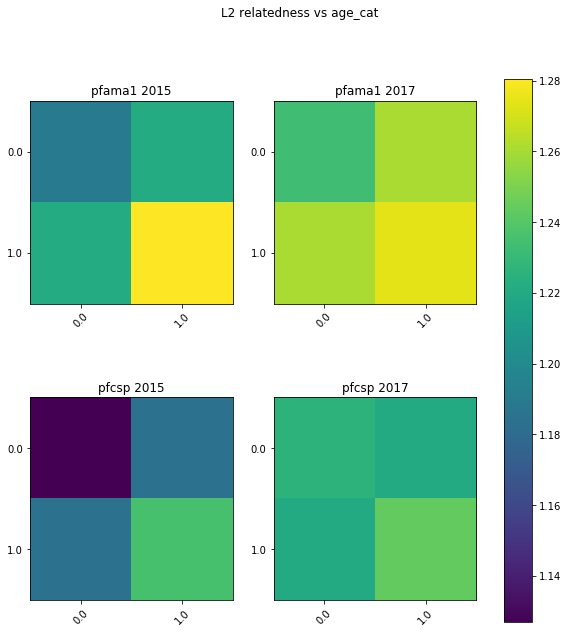

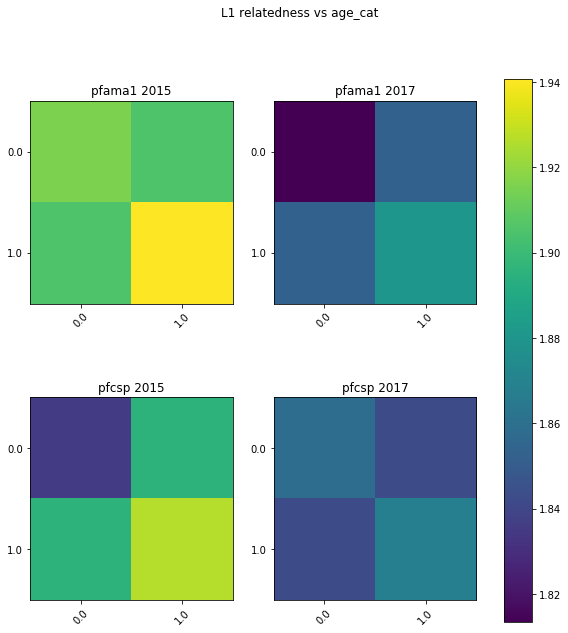

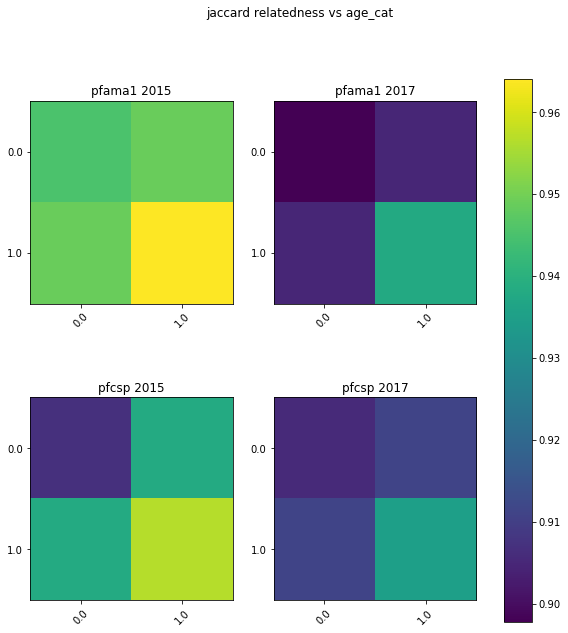

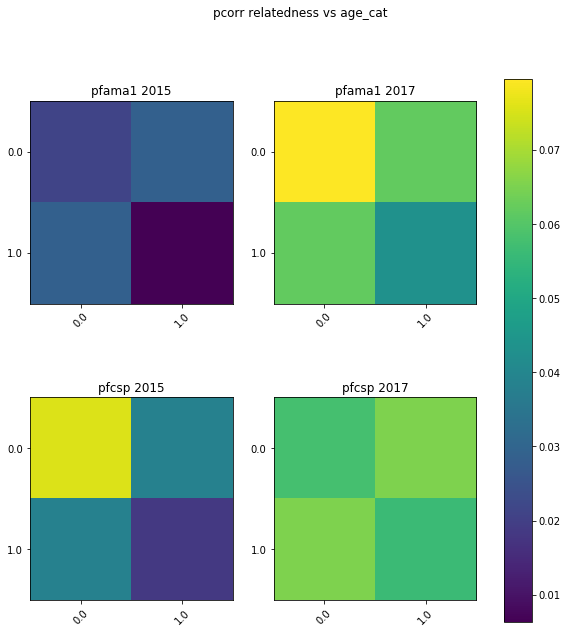

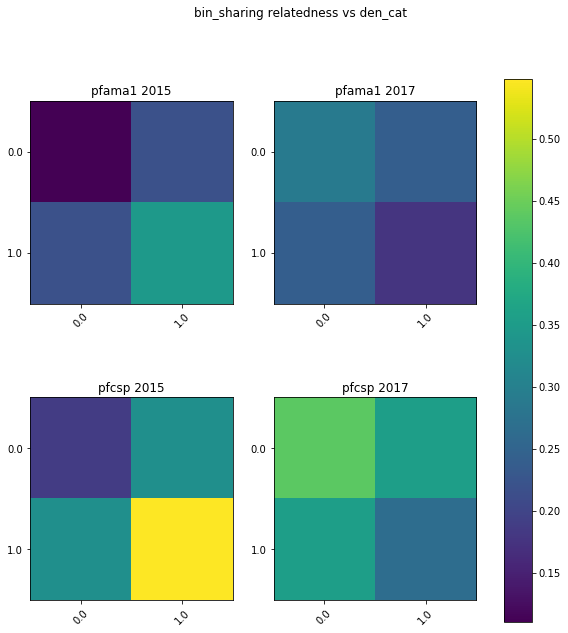

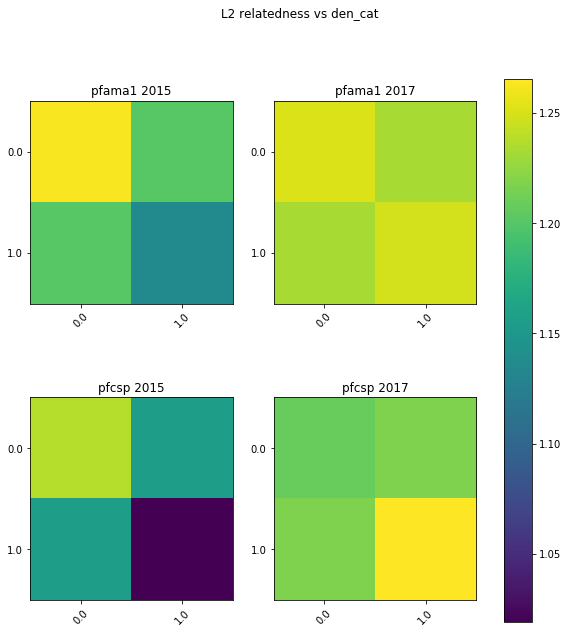

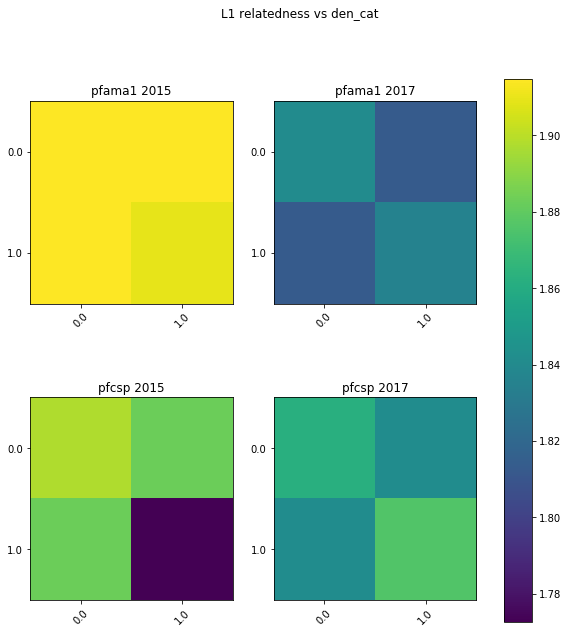

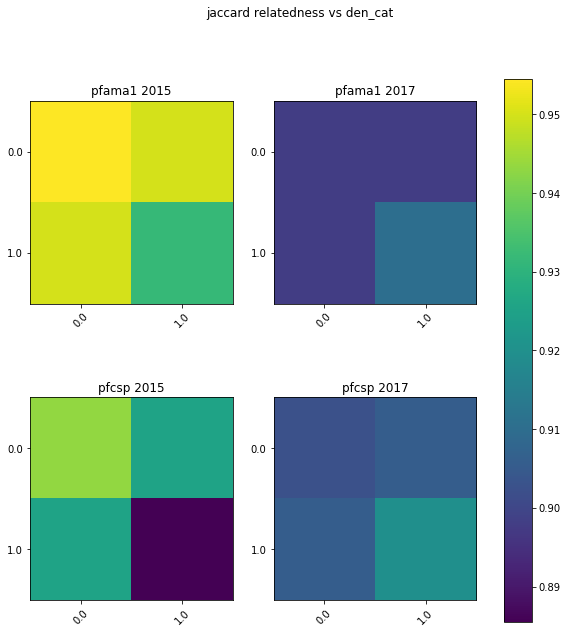

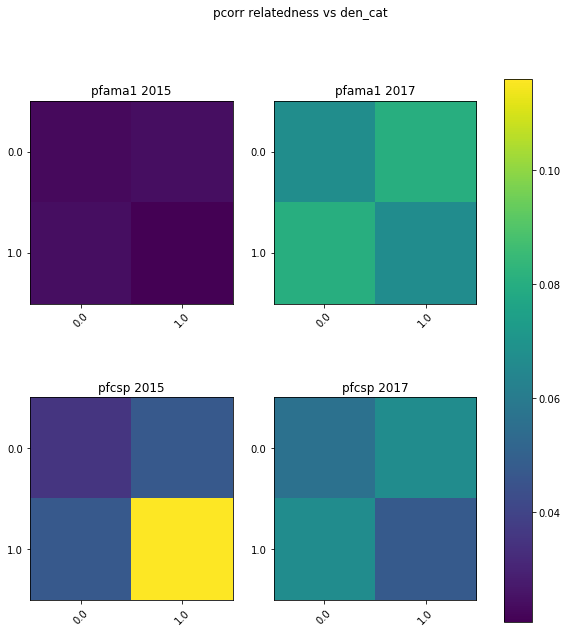

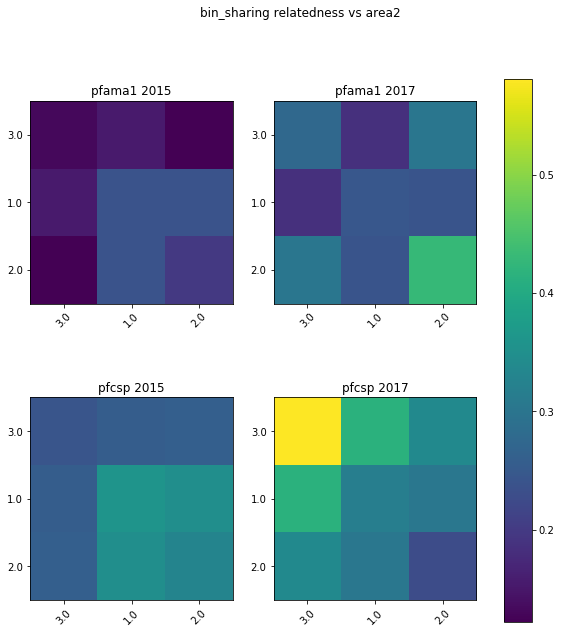

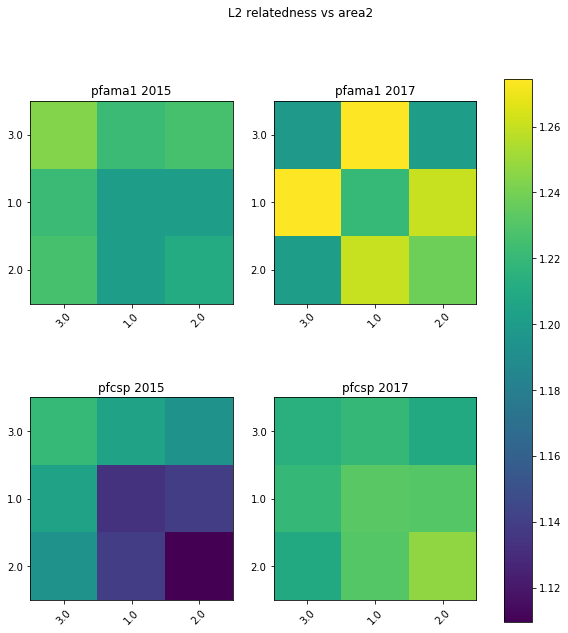

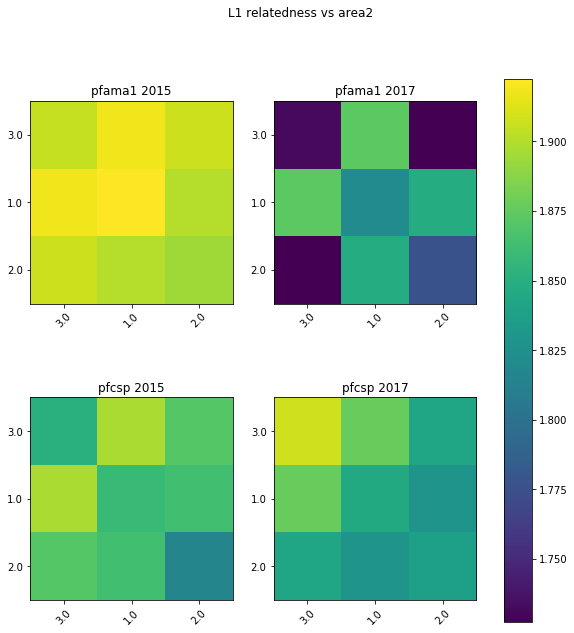

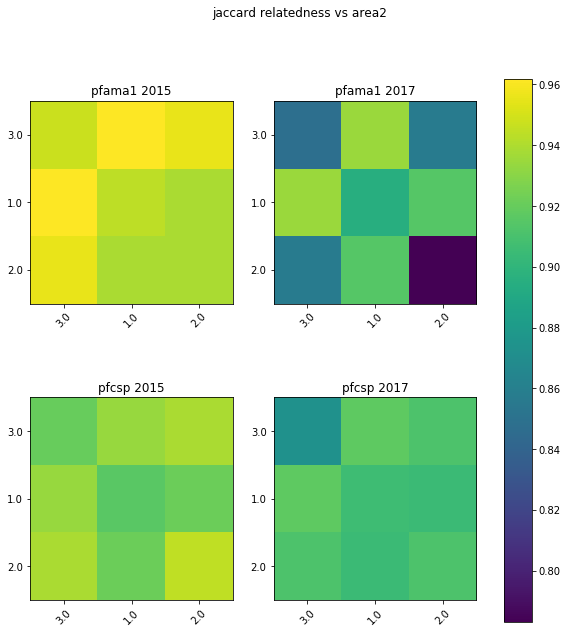

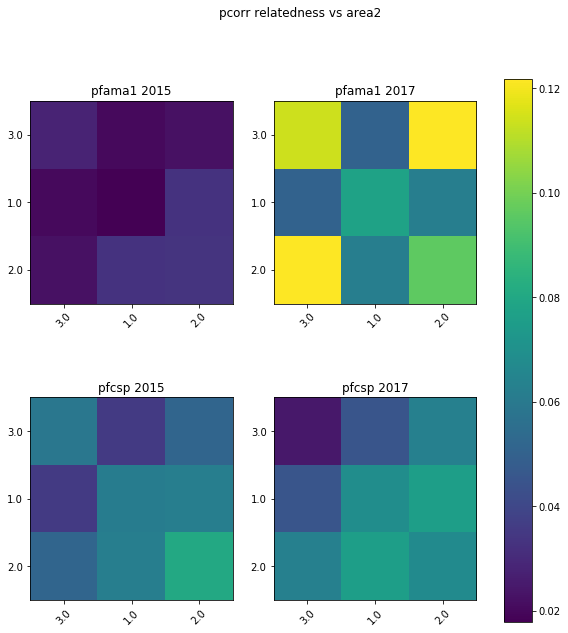

In [19]:
#Get haplotype frequencies from a selection
for category in ['gender', 'area', 'fevertemp', 'antimal', 'age_cat', 'den_cat', 'area2']: 
    types = data[category].unique()
    #list of all haplotype frequencies selected for each type
    haplotype_freqs_ama_pre = []
    haplotype_freqs_ama_post = []
    haplotype_freqs_csp_pre = []
    haplotype_freqs_csp_post = []
    for tt in types:
        hap_freq = np.array([merged_ama.loc[str(col)][:n_ama_haplotypes] for col in cols_pre if merged_ama.loc[str(col)][category] == tt], dtype = float)
        haplotype_freqs_ama_pre.append(hap_freq)
        hap_freq = np.array([merged_ama.loc[str(col)][:n_ama_haplotypes] for col in cols_post if merged_ama.loc[str(col)][category] == tt], dtype = float)
        haplotype_freqs_ama_post.append(hap_freq)
        hap_freq = np.array([merged_csp.loc[str(col)][:n_csp_haplotypes] for col in cols_pre if merged_csp.loc[str(col)][category] == tt], dtype = float)
        haplotype_freqs_csp_pre.append(hap_freq)
        hap_freq = np.array([merged_csp.loc[str(col)][:n_csp_haplotypes] for col in cols_post if merged_csp.loc[str(col)][category] == tt], dtype = float)
        haplotype_freqs_csp_post.append(hap_freq)
    
    #Get relatedness matrices for all metrics
    for mm in ['bin_sharing', 'L2', 'L1', 'jaccard', 'pcorr']:
        relat_cross_ama_pre = np.zeros((len(types), len(types)))
        relat_cross_ama_post = np.zeros((len(types), len(types)))
        relat_cross_csp_pre = np.zeros((len(types), len(types)))
        relat_cross_csp_post = np.zeros((len(types), len(types)))
        for ii, tt in enumerate(types):
            for jj, tt in enumerate(types):
                if jj == ii:
                    diag = True
                else:
                    diag = False
                #pfama1
                mat_ama_pre = relatedness_mat(haplotype_freqs_ama_pre[ii], haplotype_freqs_ama_pre[jj], method = mm)
                mat_ama_post = relatedness_mat(haplotype_freqs_ama_post[ii], haplotype_freqs_ama_post[jj], method = mm)
                relat_cross_ama_pre[ii,jj] = np.mean(mat_vals(mat_ama_pre, diag = diag))
                relat_cross_ama_post[ii,jj] = np.mean(mat_vals(mat_ama_post, diag = diag))
                #pfcsp
                mat_csp_pre = relatedness_mat(haplotype_freqs_csp_pre[ii], haplotype_freqs_csp_pre[jj], method = mm)
                mat_csp_post = relatedness_mat(haplotype_freqs_csp_post[ii], haplotype_freqs_csp_post[jj], method = mm)
                relat_cross_csp_pre[ii,jj] = np.mean(mat_vals(mat_csp_pre, diag = diag))
                relat_cross_csp_post[ii,jj] = np.mean(mat_vals(mat_csp_post, diag = diag))
                
        #Plot mean statistics between all them
        all_vals = np.concatenate((relat_cross_ama_pre, relat_cross_ama_post,relat_cross_csp_pre, relat_cross_csp_post))
        min_v = np.min(all_vals)
        max_v = np.max(all_vals)
        
        fig, axs = plt.subplots(2, 2)
        fig.set_size_inches([10,10])
        fig.suptitle(mm + ' relatedness vs ' + category)
            
        images = []
            
        images.append(axs[0,0].imshow(relat_cross_ama_pre, vmin = min_v, vmax = max_v))
        axs[0,0].set_title('pfama1 2015')
        axs[0,0].set_xticks(np.arange(len(types)))
        axs[0,0].set_xticklabels(types, rotation=45)
        axs[0,0].set_yticks(np.arange(len(types)))
        axs[0,0].set_yticklabels(types)
                
        images.append(axs[0,1].imshow(relat_cross_ama_post, vmin = min_v, vmax = max_v))
        axs[0,1].set_title('pfama1 2017')
        axs[0,1].set_xticks(np.arange(len(types)))
        axs[0,1].set_xticklabels(types, rotation=45)
        axs[0,1].set_yticks(np.arange(len(types)))
        axs[0,1].set_yticklabels(types)
                
        images.append(axs[1,0].imshow(relat_cross_csp_pre, vmin = min_v, vmax = max_v))
        axs[1,0].set_title('pfcsp 2015')
        axs[1,0].set_xticks(np.arange(len(types)))
        axs[1,0].set_xticklabels(types, rotation=45)
        axs[1,0].set_yticks(np.arange(len(types)))
        axs[1,0].set_yticklabels(types)
                
        images.append(axs[1,1].imshow(relat_cross_csp_post, vmin = min_v, vmax = max_v))
        axs[1,1].set_title('pfcsp 2017')
        axs[1,1].set_xticks(np.arange(len(types)))
        axs[1,1].set_xticklabels(types, rotation=45)
        axs[1,1].set_yticks(np.arange(len(types)))
        axs[1,1].set_yticklabels(types)
        
        fig.colorbar(images[3], ax = axs)
        plt.show()


In [28]:
mm = 'bin_sharing'
for ii in range(len(types)):
    for jj in range(len(types)):
        mat_ama_pre = relatedness_mat(haplotype_freqs_ama_pre[ii], haplotype_freqs_ama_pre[jj], method = mm)
        mat_ama_post = relatedness_mat(haplotype_freqs_ama_post[ii], haplotype_freqs_ama_post[jj], method = mm)
        if ii != jj:
            print_means(mat_ama_pre, mat_ama_post, mm + ' ' + types[ii] + ' vs ' + types[jj] + ' pfama1', diag = True)
        else:
            print_means(mat_ama_pre, mat_ama_post, mm + ' ' + types[ii] + ' vs ' + types[jj] + ' pfama1', diag = True)
        print("")
        mat_csp_pre = relatedness_mat(haplotype_freqs_csp_pre[ii], haplotype_freqs_csp_pre[jj], method = mm)
        mat_csp_post = relatedness_mat(haplotype_freqs_csp_post[ii], haplotype_freqs_csp_post[jj], method = mm)
        if ii != jj:
            print_means(mat_csp_pre, mat_csp_post, mm + ' ' + types[ii] + ' vs ' + types[jj] + ' pfcsp', diag = True)
        else:
            print_means(mat_csp_pre, mat_csp_post, mm + ' ' + types[ii] + ' vs ' + types[jj] + ' pfcsp', diag = True)
        print("")
        
mm = 'pcorr'
for ii in range(len(types)):
    for jj in range(len(types)):
        mat_ama_pre = relatedness_mat(haplotype_freqs_ama_pre[ii], haplotype_freqs_ama_pre[jj], method = mm)
        mat_ama_post = relatedness_mat(haplotype_freqs_ama_post[ii], haplotype_freqs_ama_post[jj], method = mm)
        if ii != jj:
            print_means(mat_ama_pre, mat_ama_post, mm + ' ' + types[ii] + ' vs ' + types[jj] + ' pfama1', diag = True)
        else:
            print_means(mat_ama_pre, mat_ama_post, mm + ' ' + types[ii] + ' vs ' + types[jj] + ' pfama1', diag = True)
        print("")
        mat_csp_pre = relatedness_mat(haplotype_freqs_csp_pre[ii], haplotype_freqs_csp_pre[jj], method = mm)
        mat_csp_post = relatedness_mat(haplotype_freqs_csp_post[ii], haplotype_freqs_csp_post[jj], method = mm)
        if ii != jj:
            print_means(mat_csp_pre, mat_csp_post, mm + ' ' + types[ii] + ' vs ' + types[jj] + ' pfcsp', diag = True)
        else:
            print_means(mat_csp_pre, mat_csp_post, mm + ' ' + types[ii] + ' vs ' + types[jj] + ' pfcsp', diag = True)
        print("")
        

TypeError: cannot concatenate 'str' and 'numpy.float64' objects

# Individual relatedness for each population 

### L2 

In [20]:
ind_dist_pre_ama = (np.sum(dist_mat_pre_ama, axis = 0) - 1.)/(len(dist_mat_pre_ama) - 1)
ind_dist_post_ama = (np.sum(dist_mat_post_ama, axis = 0) - 1.)/(len(dist_mat_post_ama) - 1)
ind_dist_pre_csp = (np.sum(dist_mat_pre_csp, axis = 0) - 1.)/(len(dist_mat_pre_csp) - 1)
ind_dist_post_csp = (np.sum(dist_mat_post_csp, axis = 0) - 1.)/(len(dist_mat_post_csp) - 1)

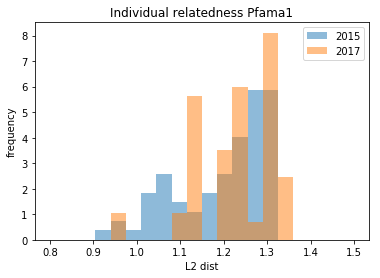

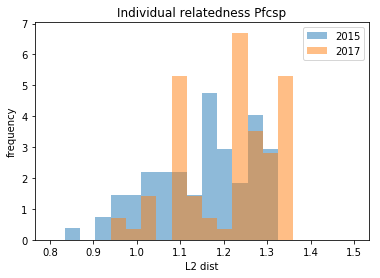

In [31]:
plt.hist(ind_dist_pre_ama, 20, normed = True, range = [0.8,1.5], label = '2015', alpha = .5)
plt.hist(ind_dist_post_ama, 20, normed = True, range = [0.8,1.5], label = '2017', alpha = .5)
plt.xlabel('L2 dist')
plt.title('Individual relatedness Pfama1')
plt.ylabel('frequency')
plt.legend()
plt.show()

plt.hist(ind_dist_pre_csp, 20, normed = True, range = [0.8,1.5], label = '2015', alpha = .5)
plt.hist(ind_dist_post_csp, 20, normed = True, range = [0.8,1.5], label = '2017', alpha = .5)
plt.xlabel('L2 dist')
plt.title('Individual relatedness Pfcsp')
plt.ylabel('frequency')
plt.legend()
plt.show()


### L1

In [21]:
ind_l1_pre_ama = (np.sum(l1_mat_pre_ama, axis = 0) - 1.)/(len(l1_mat_pre_ama) - 1)
ind_l1_post_ama = (np.sum(l1_mat_post_ama, axis = 0) - 1.)/(len(l1_mat_post_ama) - 1)
ind_l1_pre_csp = (np.sum(l1_mat_pre_csp, axis = 0) - 1.)/(len(l1_mat_pre_csp) - 1)
ind_l1_post_csp = (np.sum(l1_mat_post_csp, axis = 0) - 1.)/(len(l1_mat_post_csp) - 1)

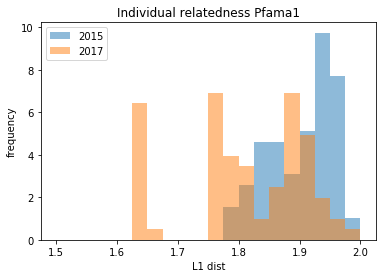

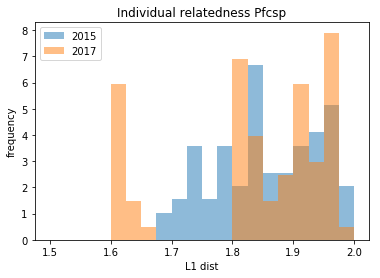

In [33]:
plt.hist(ind_l1_pre_ama, 20, normed = True, range = [1.5,2.], label = '2015', alpha = .5)
plt.hist(ind_l1_post_ama, 20, normed = True, range = [1.5,2], label = '2017', alpha = .5)
plt.xlabel('L1 dist')
plt.title('Individual relatedness Pfama1')
plt.ylabel('frequency')
plt.legend()
plt.show()

plt.hist(ind_l1_pre_csp, 20, normed = True, range = [1.5,2.], label = '2015', alpha = .5)
plt.hist(ind_l1_post_csp, 20, normed = True, range = [1.5,2.], label = '2017', alpha = .5)
plt.xlabel('L1 dist')
plt.title('Individual relatedness Pfcsp')
plt.ylabel('frequency')
plt.legend()
plt.show()


### Jaccard 

In [22]:
ind_jacc_pre_ama = (np.sum(jacc_mat_pre_ama, axis = 0) - 1.)/(len(jacc_mat_pre_ama) - 1)
ind_jacc_post_ama = (np.sum(jacc_mat_post_ama, axis = 0) - 1.)/(len(jacc_mat_post_ama) - 1)
ind_jacc_pre_csp = (np.sum(jacc_mat_pre_csp, axis = 0) - 1.)/(len(jacc_mat_pre_csp) - 1)
ind_jacc_post_csp = (np.sum(jacc_mat_post_csp, axis = 0) - 1.)/(len(jacc_mat_post_csp) - 1)

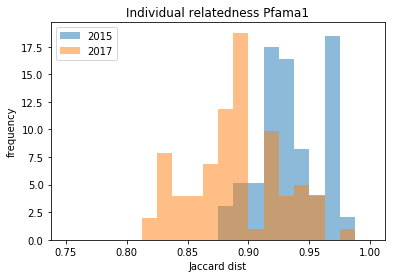

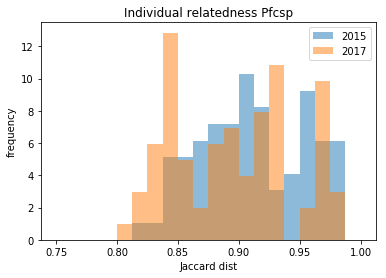

In [35]:
plt.hist(ind_jacc_pre_ama, 20, normed = True, range = [.75,1], label = '2015', alpha = .5)
plt.hist(ind_jacc_post_ama, 20, normed = True, range = [.75,1], label = '2017', alpha = .5)
plt.xlabel('Jaccard dist')
plt.title('Individual relatedness Pfama1')
plt.ylabel('frequency')
plt.legend()
plt.show()

plt.hist(ind_jacc_pre_csp, 20, normed = True, range = [.75,1], label = '2015', alpha = .5)
plt.hist(ind_jacc_post_csp, 20, normed = True, range = [.75,1], label = '2017', alpha = .5)
plt.xlabel('Jaccard dist')
plt.title('Individual relatedness Pfcsp')
plt.ylabel('frequency')
plt.legend()
plt.show()


### Pearson CC 

In [23]:
ind_pcorr_pre_ama = (np.sum(pcor_mat_pre_ama, axis = 0) - 1.)/(len(pcor_mat_pre_ama) - 1)
ind_pcorr_post_ama = (np.sum(pcor_mat_post_ama, axis = 0) - 1.)/(len(pcor_mat_post_ama) - 1)
ind_pcorr_pre_csp = (np.sum(pcor_mat_pre_csp, axis = 0) - 1.)/(len(pcor_mat_pre_csp) - 1)
ind_pcorr_post_csp = (np.sum(pcor_mat_post_csp, axis = 0) - 1.)/(len(pcor_mat_post_csp) - 1)

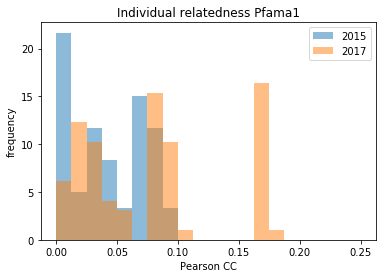

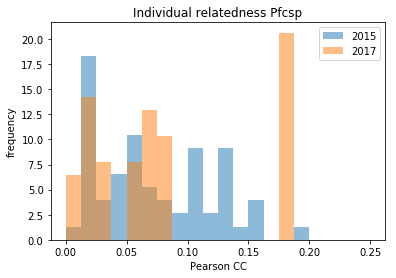

In [37]:
plt.hist(ind_pcorr_pre_ama, 20, normed = True, range = [0,.25], label = '2015', alpha = .5)
plt.hist(ind_pcorr_post_ama, 20, normed = True, range = [0,.25], label = '2017', alpha = .5)
plt.xlabel('Pearson CC')
plt.title('Individual relatedness Pfama1')
plt.ylabel('frequency')
plt.legend()
plt.show()

plt.hist(ind_pcorr_pre_csp, 20, normed = True, range = [0,.25], label = '2015', alpha = .5)
plt.hist(ind_pcorr_post_csp, 20, normed = True, range = [0,.25], label = '2017', alpha = .5)
plt.xlabel('Pearson CC')
plt.title('Individual relatedness Pfcsp')
plt.ylabel('frequency')
plt.legend()
plt.show()


# Individual relatedness vs other properties from data

### TODO:

- Get individual relatedness vs populations: histograms of individual relatedness within its population and in different populations (e.g. different areas, gender, etc.)

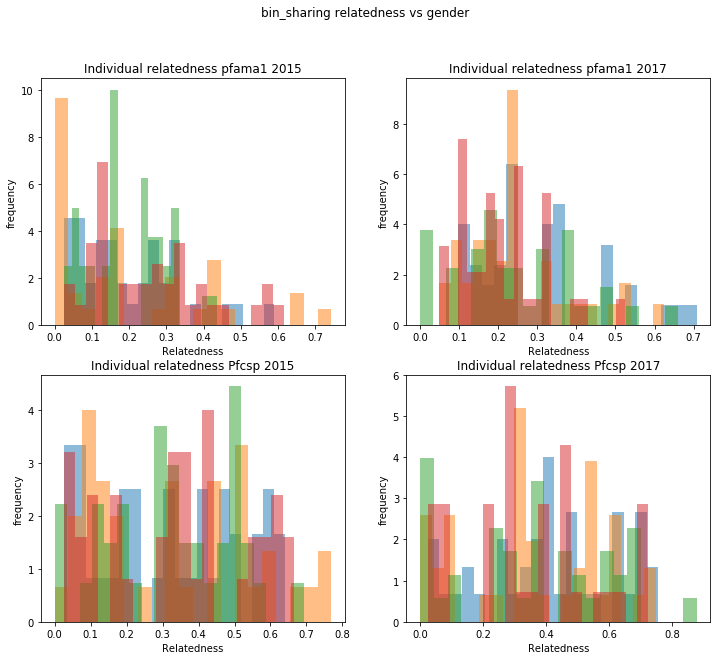

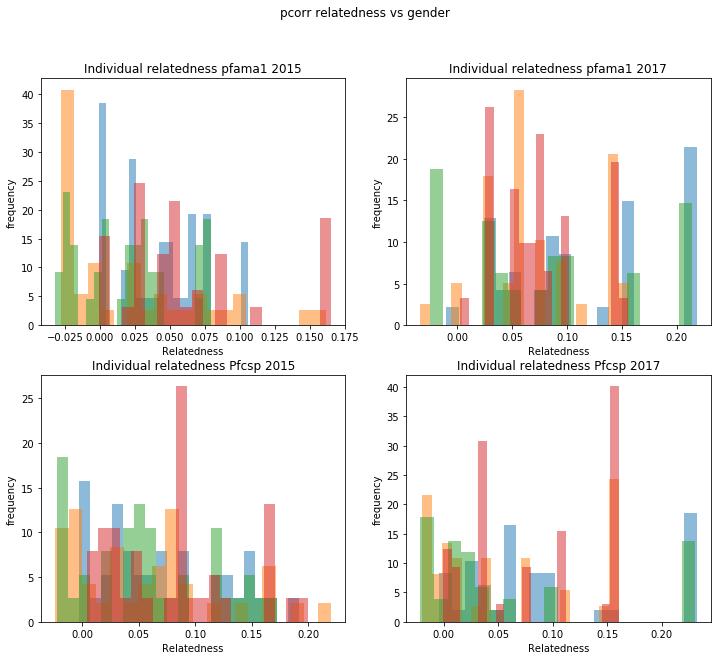

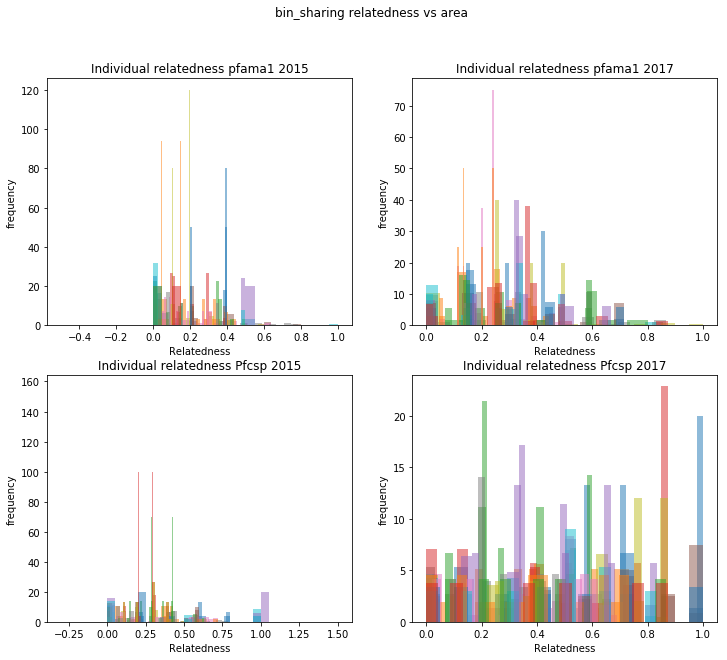

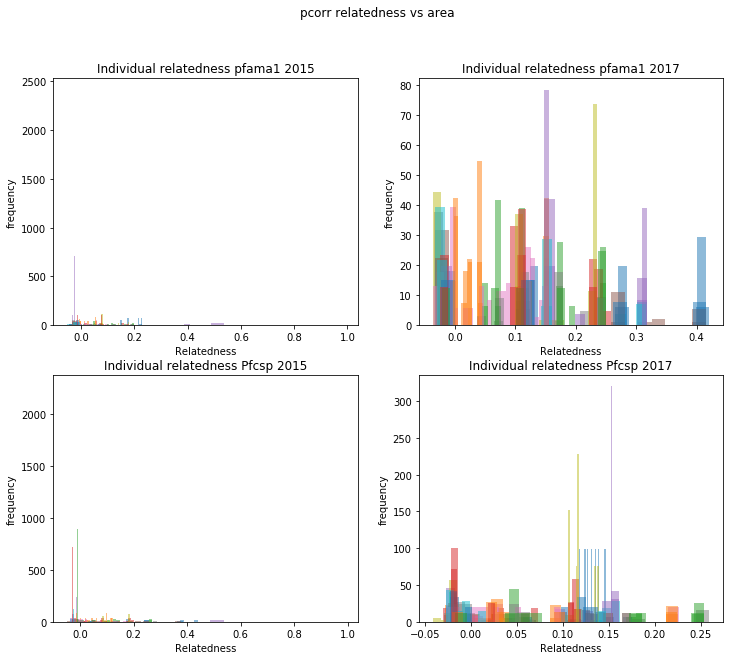

In [24]:
#Get haplotype frequencies from a selection
for category in ['gender', 'area']:#, 'fevertemp', 'antimal', 'age_cat', 'den_cat', 'area2']: 
    types = data[category].unique()
    #list of all haplotype frequencies selected for each type
    haplotype_freqs_ama_pre = []
    haplotype_freqs_ama_post = []
    haplotype_freqs_csp_pre = []
    haplotype_freqs_csp_post = []
    for tt in types:
        hap_freq = np.array([merged_ama.loc[str(col)][:n_ama_haplotypes] for col in cols_pre if merged_ama.loc[str(col)][category] == tt], dtype = float)
        haplotype_freqs_ama_pre.append(hap_freq)
        hap_freq = np.array([merged_ama.loc[str(col)][:n_ama_haplotypes] for col in cols_post if merged_ama.loc[str(col)][category] == tt], dtype = float)
        haplotype_freqs_ama_post.append(hap_freq)
        hap_freq = np.array([merged_csp.loc[str(col)][:n_csp_haplotypes] for col in cols_pre if merged_csp.loc[str(col)][category] == tt], dtype = float)
        haplotype_freqs_csp_pre.append(hap_freq)
        hap_freq = np.array([merged_csp.loc[str(col)][:n_csp_haplotypes] for col in cols_post if merged_csp.loc[str(col)][category] == tt], dtype = float)
        haplotype_freqs_csp_post.append(hap_freq)
    
    #Get relatedness matrices for all metrics
    for mm in ['bin_sharing', 'pcorr']:#, 'L2', 'L1', 'jaccard', 'pcorr']:
        fig, axs = plt.subplots(2, 2)
        fig.set_size_inches([12,10])
        fig.suptitle(mm + ' relatedness vs ' + category)
        for ii, tt in enumerate(types):
            for jj, tt in enumerate(types):
                if jj == ii:
                    diag = True
                else:
                    diag = False
                ind_pcorr_pre_ama = np.zeros((len(types), len(types), len(haplotype_freqs_ama_pre[ii])))
                ind_pcorr_post_ama = np.zeros((len(types), len(types), len(haplotype_freqs_ama_post[ii])))
                ind_pcorr_pre_csp = np.zeros((len(types), len(types), len(haplotype_freqs_csp_pre[ii])))
                ind_pcorr_post_csp = np.zeros((len(types), len(types), len(haplotype_freqs_csp_post[ii])))
                #pfama1
                mat_ama_pre = relatedness_mat(haplotype_freqs_ama_pre[ii], haplotype_freqs_ama_pre[jj], method = mm)
                mat_ama_post = relatedness_mat(haplotype_freqs_ama_post[ii], haplotype_freqs_ama_post[jj], method = mm)
                #relat_cross_ama_pre[ii,jj] = np.mean(mat_vals(mat_ama_pre, diag = diag))
                #relat_cross_ama_post[ii,jj] = np.mean(mat_vals(mat_ama_post, diag = diag))
                #pfcsp
                mat_csp_pre = relatedness_mat(haplotype_freqs_csp_pre[ii], haplotype_freqs_csp_pre[jj], method = mm)
                mat_csp_post = relatedness_mat(haplotype_freqs_csp_post[ii], haplotype_freqs_csp_post[jj], method = mm)
                #relat_cross_csp_pre[ii,jj] = np.mean(mat_vals(mat_csp_pre, diag = diag))
                #relat_cross_csp_post[ii,jj] = np.mean(mat_vals(mat_csp_post, diag = diag))
                
                ind_pcorr_pre_ama[ii,jj] = np.mean(mat_ama_pre, axis = 1)
                ind_pcorr_post_ama[ii,jj] = np.mean(mat_ama_post, axis = 1)
                ind_pcorr_pre_csp[ii,jj] = np.mean(mat_csp_pre, axis = 1)
                ind_pcorr_post_csp[ii,jj] = np.mean(mat_csp_post, axis = 1)
                
        #Plot mean statistics between all them
          
                axs[0,0].hist(ind_pcorr_pre_ama[ii,jj], 20, normed = True, label = types[ii] + ' vs ' + types[jj], alpha = .5)

                axs[0,1].hist(ind_pcorr_post_ama[ii,jj], 20, normed = True, label = types[ii] + ' vs ' + types[jj], alpha = .5)
        
                axs[1,0].hist(ind_pcorr_pre_csp[ii,jj], 20, normed = True, label = types[ii] + ' vs ' + types[jj], alpha = .5)

                axs[1,1].hist(ind_pcorr_post_csp[ii,jj], 20, normed = True, label = types[ii] + ' vs ' + types[jj], alpha = .5)
                
        axs[0,0].set_xlabel('Relatedness')
        axs[0,0].set_ylabel('frequency')
        #axs[0,0].legend()
        axs[0,0].set_title('Individual relatedness pfama1 2015')
        
        axs[0,1].set_xlabel('Relatedness')
        axs[0,1].set_ylabel('frequency')
        #axs[0,1].legend()
        axs[0,1].set_title('Individual relatedness pfama1 2017')
        
        axs[1,0].set_xlabel('Relatedness')
        axs[1,0].set_ylabel('frequency')
        #axs[1,0].legend()
        axs[1,0].set_title('Individual relatedness Pfcsp 2015')

        axs[1,1].set_xlabel('Relatedness')
        axs[1,1].set_ylabel('frequency')
        #axs[1,1].legend()
        axs[1,1].set_title('Individual relatedness Pfcsp 2017')

        
        plt.show()


# Correlation between different metrics

### TODO:

- Scatter or hexbin plots and Pearson CCs between all metrics for pre and post ama and csp

- make matrix/table showing the Pearson CC for all comparisons

- scatter and Pearson CC for non-identical cases, for high and low extremes for BS = 0 and BS = 1

In [25]:
all_l1 = np.concatenate((mat_vals(l1_mat_pre_ama), mat_vals(l1_mat_post_ama), mat_vals(l1_mat_pre_csp), mat_vals(l1_mat_post_csp)))
all_dist = np.concatenate((mat_vals(dist_mat_pre_ama), mat_vals(dist_mat_post_ama), mat_vals(dist_mat_pre_csp), mat_vals(dist_mat_post_csp)))
all_bin = np.concatenate((mat_vals(bin_mat_pre_ama), mat_vals(bin_mat_post_ama), mat_vals(bin_mat_pre_csp), mat_vals(bin_mat_post_csp)))
all_jacc = np.concatenate((mat_vals(jacc_mat_pre_ama), mat_vals(jacc_mat_post_ama), mat_vals(jacc_mat_pre_csp), mat_vals(jacc_mat_post_csp)))
all_pcor = np.concatenate((mat_vals(pcor_mat_pre_ama), mat_vals(pcor_mat_post_ama), mat_vals(pcor_mat_pre_csp), mat_vals(pcor_mat_post_csp)))

### Scatter comparisons

Pearson CC between BS and BS: 1.0
Pearson CC between BS and JD: -0.7484726265316249


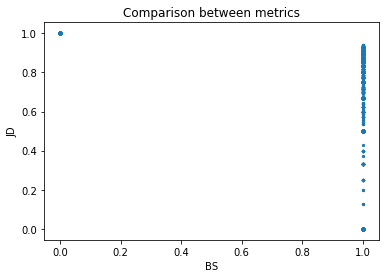

Pearson CC between BS and L1: -0.4989407751578469


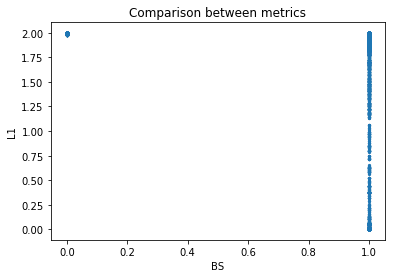

Pearson CC between BS and L2: -0.5425968325150965


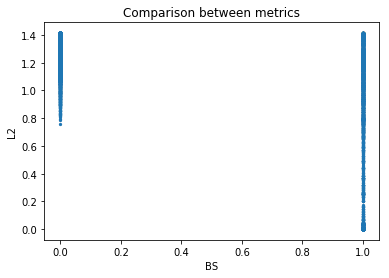

Pearson CC between BS and PCC: 0.5130052285855075


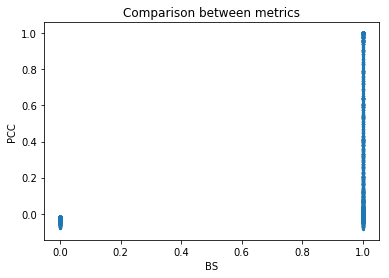

Pearson CC between JD and BS: -0.7484726265316249
Pearson CC between JD and JD: 1.0
Pearson CC between JD and L1: 0.7095583865126056


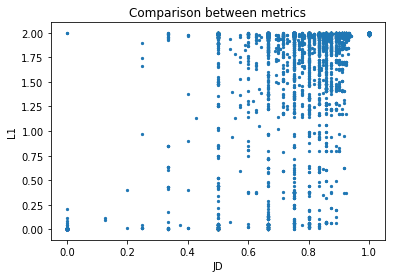

Pearson CC between JD and L2: 0.6545439975136708


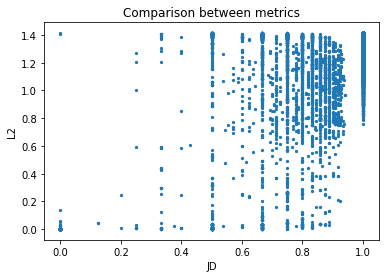

Pearson CC between JD and PCC: -0.6747491284220719


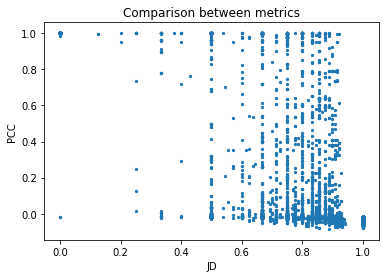

Pearson CC between L1 and BS: -0.4989407751578469
Pearson CC between L1 and JD: 0.7095583865126056
Pearson CC between L1 and L1: 1.0
Pearson CC between L1 and L2: 0.9148769006580837


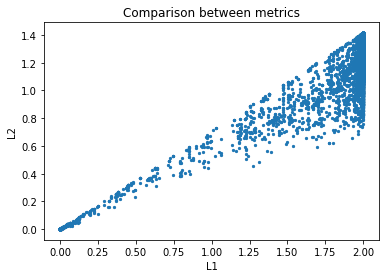

Pearson CC between L1 and PCC: -0.9804357577919827


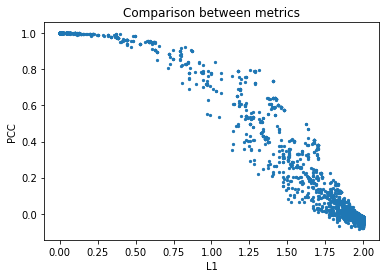

Pearson CC between L2 and BS: -0.5425968325150965
Pearson CC between L2 and JD: 0.6545439975136708
Pearson CC between L2 and L1: 0.9148769006580837
Pearson CC between L2 and L2: 1.0
Pearson CC between L2 and PCC: -0.8928712767274041


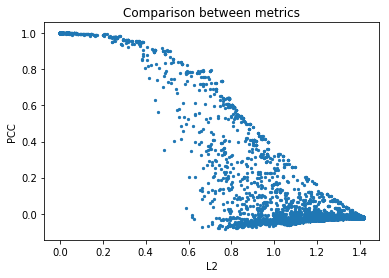

Pearson CC between PCC and BS: 0.5130052285855075
Pearson CC between PCC and JD: -0.6747491284220719
Pearson CC between PCC and L1: -0.9804357577919827
Pearson CC between PCC and L2: -0.8928712767274041
Pearson CC between PCC and PCC: 1.0


In [45]:
metrics = ['BS', 'JD', 'L1', 'L2', 'PCC']
list_metrics = [all_bin, all_jacc, all_l1, all_dist, all_pcor]
pcorrs = np.zeros((len(metrics), len(metrics)))
for ii, m1 in enumerate(list_metrics):
    for jj, m2 in enumerate(list_metrics):
        pcc = sci_stats.pearsonr(m1, m2)[0]
        pcorrs[ii,jj] = pcc
        print("Pearson CC between "+metrics[ii]+" and "+metrics[jj]+": " + str(pcc))
        if ii < jj:
            plt.scatter(m1, m2, s = 5)
            plt.title('Comparison between metrics')
            plt.xlabel(metrics[ii])
            plt.ylabel(metrics[jj])
            plt.show()


Pearson CC between JD and JD: 1.0
Pearson CC between JD and L1: 0.7095583865126056


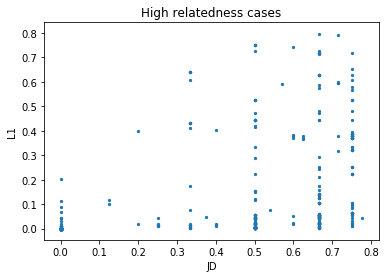

Pearson CC for high relatedness cases between JD and L1: 0.44789578486910075


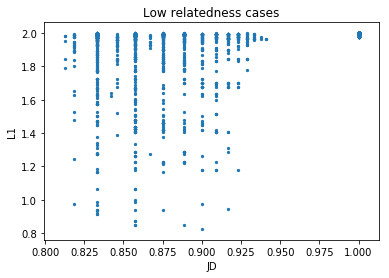

Pearson CC for low relatedness cases between JD and L1: 0.5271106114011456


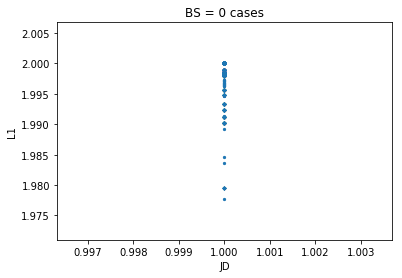

Pearson CC for BS = 0 cases between JD and L1: nan


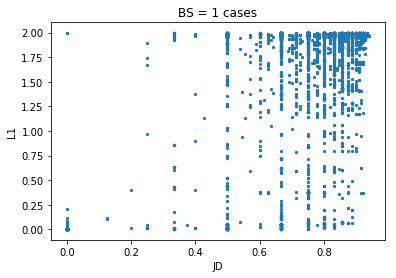

Pearson CC for BS = 1 cases between JD and L1: 0.5848335808002153
Pearson CC between JD and L2: 0.6545439975136708


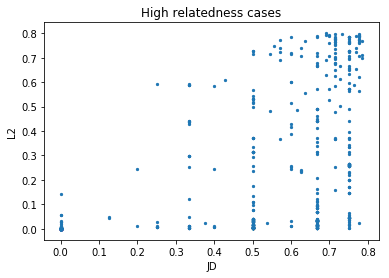

Pearson CC for high relatedness cases between JD and L2: 0.5298909031590459


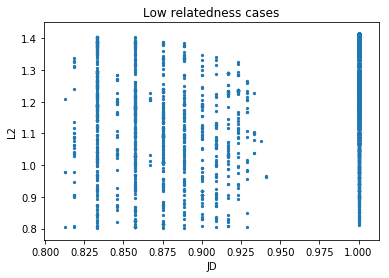

Pearson CC for low relatedness cases between JD and L2: 0.4297041194687809


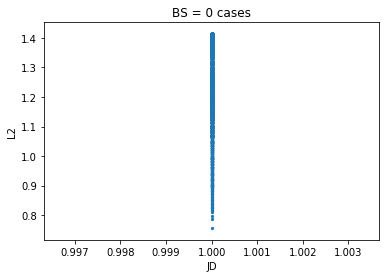

Pearson CC for BS = 0 cases between JD and L2: nan


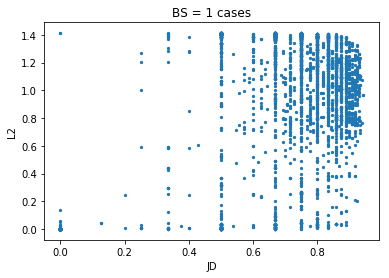

Pearson CC for BS = 1 cases between JD and L2: 0.4824579832271806
Pearson CC between JD and PCC: -0.6747491284220719


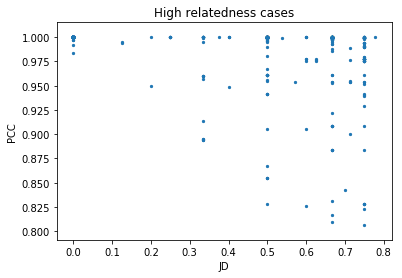

Pearson CC for high relatedness cases between JD and PCC: -0.2937266339514261


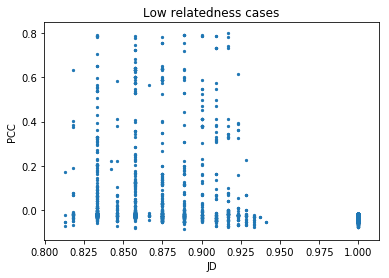

Pearson CC for low relatedness cases between JD and PCC: -0.4358117689727932


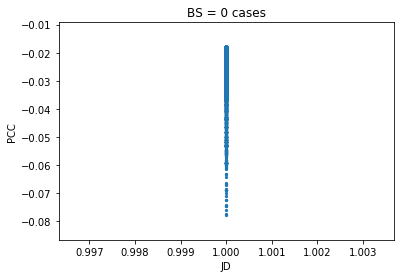

Pearson CC for BS = 0 cases between JD and PCC: nan


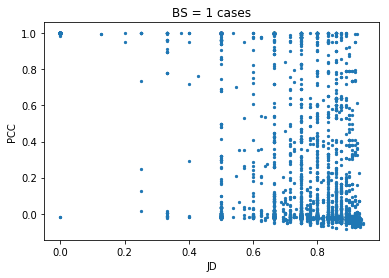

Pearson CC for BS = 1 cases between JD and PCC: -0.5110731533352707
Pearson CC between L1 and JD: 0.7095583865126056
Pearson CC between L1 and L1: 1.0
Pearson CC between L1 and L2: 0.9148769006580837


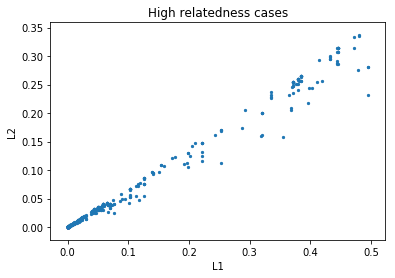

Pearson CC for high relatedness cases between L1 and L2: 0.9942843350448347


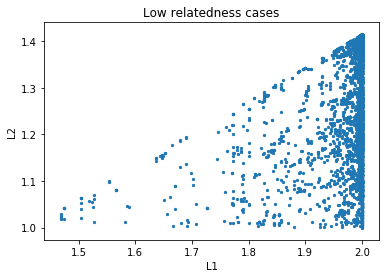

Pearson CC for low relatedness cases between L1 and L2: 0.3198580723493264


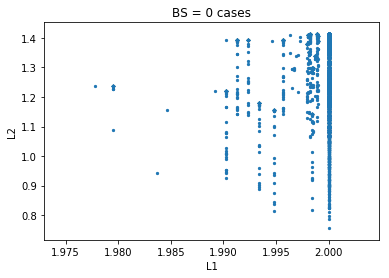

Pearson CC for BS = 0 cases between L1 and L2: 0.11839363892042613


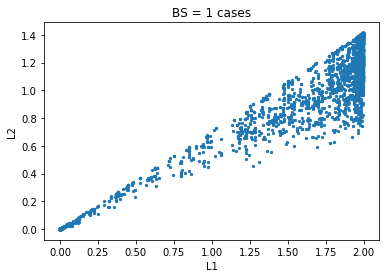

Pearson CC for BS = 1 cases between L1 and L2: 0.9570933384599443
Pearson CC between L1 and PCC: -0.9804357577919827


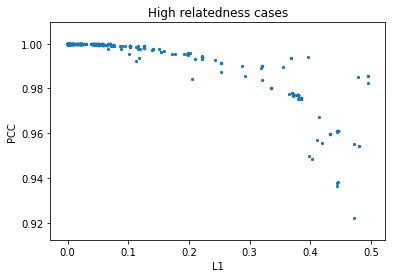

Pearson CC for high relatedness cases between L1 and PCC: -0.8848329335976334


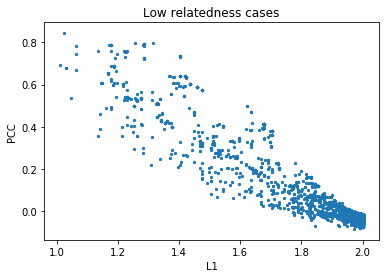

Pearson CC for low relatedness cases between L1 and PCC: -0.943577189593085


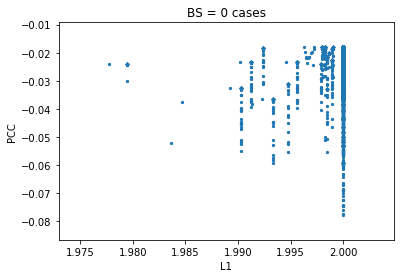

Pearson CC for BS = 0 cases between L1 and PCC: 0.07642977810611717


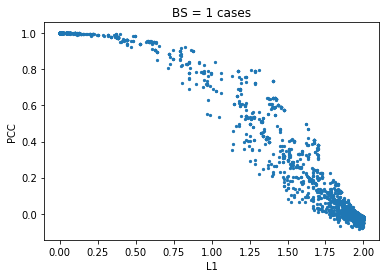

Pearson CC for BS = 1 cases between L1 and PCC: -0.9744009633501828
Pearson CC between L2 and JD: 0.6545439975136708
Pearson CC between L2 and L1: 0.9148769006580837
Pearson CC between L2 and L2: 1.0
Pearson CC between L2 and PCC: -0.8928712767274041


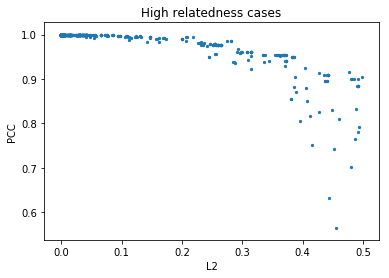

Pearson CC for high relatedness cases between L2 and PCC: -0.7770182909457012


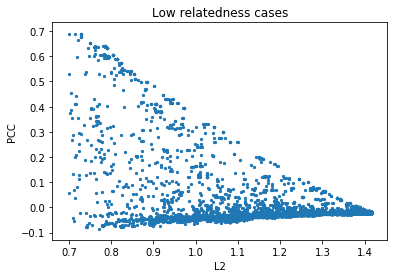

Pearson CC for low relatedness cases between L2 and PCC: -0.47030145574213084


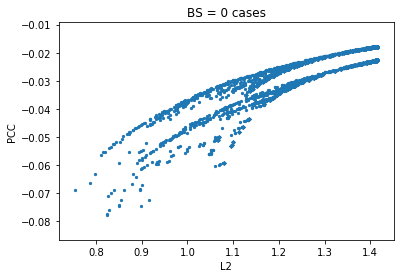

Pearson CC for BS = 0 cases between L2 and PCC: 0.8630350100550849


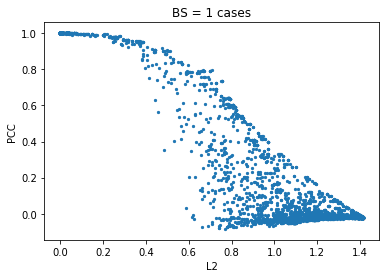

Pearson CC for BS = 1 cases between L2 and PCC: -0.9339550736472493
Pearson CC between PCC and JD: -0.6747491284220719
Pearson CC between PCC and L1: -0.9804357577919827
Pearson CC between PCC and L2: -0.8928712767274041
Pearson CC between PCC and PCC: 1.0


In [61]:
#Same as before but for extremes relatedness cases
metrics = ['JD', 'L1', 'L2', 'PCC']
high_relatedness_vals = [.8, .5, .5, .6]
low_relatedness_vals = [.8, 1., .7, .5]
list_metrics = [all_jacc, all_l1, all_dist, all_pcor]
pcorrs = np.zeros((len(metrics), len(metrics)))
for ii, m1 in enumerate(list_metrics):
    for jj, m2 in enumerate(list_metrics):
        pcc = sci_stats.pearsonr(m1, m2)[0]
        pcorrs[ii,jj] = pcc
        print("Pearson CC between "+metrics[ii]+" and "+metrics[jj]+": " + str(pcc))
        if ii < jj:
            if metrics[ii] == 'PCC':
                filt1 = m1 > high_relatedness_vals[ii]
            else:
                filt1 = m1 < high_relatedness_vals[ii]
            if metrics[jj] == 'PCC':
                filt2 = m2 > high_relatedness_vals[ii]
            else:
                filt2 = m2 < high_relatedness_vals[ii]
            plt.scatter(m1[filt1*filt2], m2[filt1*filt2], s = 5)
            plt.title('High relatedness cases')
            plt.xlabel(metrics[ii])
            plt.ylabel(metrics[jj])
            plt.show()
            pcc = sci_stats.pearsonr(m1[filt1*filt2], m2[filt1*filt2])[0]
            print("Pearson CC for high relatedness cases between "+metrics[ii]+" and "+metrics[jj]+": " + str(pcc))
            
            if metrics[ii] == 'PCC':
                filt1 = m1 < low_relatedness_vals[ii]
            else:
                filt1 = m1 > low_relatedness_vals[ii]
            if metrics[jj] == 'PCC':
                filt2 = m2 < low_relatedness_vals[ii]
            else:
                filt2 = m2 > low_relatedness_vals[ii]
            plt.scatter(m1[filt1*filt2], m2[filt1*filt2], s = 5)
            plt.title('Low relatedness cases')
            plt.xlabel(metrics[ii])
            plt.ylabel(metrics[jj])
            plt.show()
            pcc = sci_stats.pearsonr(m1[filt1*filt2], m2[filt1*filt2])[0]
            print("Pearson CC for low relatedness cases between "+metrics[ii]+" and "+metrics[jj]+": " + str(pcc))
            
            filt = all_bin == 0
            plt.scatter(m1[filt], m2[filt], s = 5)
            plt.title('BS = 0 cases')
            plt.xlabel(metrics[ii])
            plt.ylabel(metrics[jj])
            plt.show()
            pcc = sci_stats.pearsonr(m1[filt], m2[filt])[0]
            print("Pearson CC for BS = 0 cases between "+metrics[ii]+" and "+metrics[jj]+": " + str(pcc))

            
            filt = all_bin == 1
            plt.scatter(m1[filt], m2[filt], s = 5)
            plt.title('BS = 1 cases')
            plt.xlabel(metrics[ii])
            plt.ylabel(metrics[jj])
            plt.show()
            pcc = sci_stats.pearsonr(m1[filt], m2[filt])[0]
            print("Pearson CC for BS = 1 cases between "+metrics[ii]+" and "+metrics[jj]+": " + str(pcc))


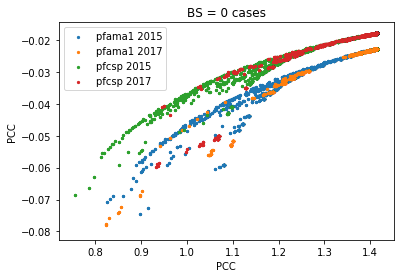

In [58]:
filt = bin_mat_pre_ama == 0
plt.scatter(dist_mat_pre_ama[filt], pcor_mat_pre_ama[filt], s = 5, label = 'pfama1 2015')
filt = bin_mat_post_ama == 0
plt.scatter(dist_mat_post_ama[filt], pcor_mat_post_ama[filt], s = 5, label = 'pfama1 2017')
filt = bin_mat_pre_csp == 0
plt.scatter(dist_mat_pre_csp[filt], pcor_mat_pre_csp[filt], s = 5, label = 'pfcsp 2015')
filt = bin_mat_post_csp == 0
plt.scatter(dist_mat_post_csp[filt], pcor_mat_post_csp[filt], s = 5, label = 'pfcsp 2017')
plt.title('BS = 0 cases')
plt.xlabel(metrics[ii])
plt.ylabel(metrics[jj])
plt.legend()
plt.show()

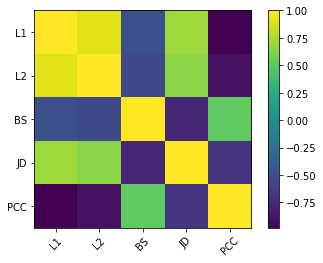

In [146]:
plt.imshow(pcorrs)
plt.xticks(np.arange(len(metrics)), metrics, rotation=45)
plt.yticks(np.arange(len(metrics)), metrics)
plt.colorbar()

# TEST 

### This tests measures the change in the metrics for random samples due to the reduction of haplotypes

In [27]:
n_s = 1000
n_pre = 70
n_post = 20
pre = np.zeros((n_s,n_pre))
post = np.zeros((n_s,n_post))
for i in range(n_s):
    for j in range(5):
        randint = np.random.randint(n_pre)
        pre[i, randint] += .2
        randint = np.random.randint(n_post)
        post[i, randint] += .2

In [88]:
print "bs"
mean_pre_bs, err_pre_bs = mat_mean_err(relatedness_mat(pre,pre, method = 'bin_sharing'))
print(mean_pre_bs, err_pre_bs)

mean_post_bs, err_post_bs = mat_mean_err(relatedness_mat(post,post, method = 'bin_sharing'))
print(mean_post_bs, err_post_bs)
print("")
print "jd"

mean_pre_jd, err_pre_jd = mat_mean_err(relatedness_mat(pre,pre, method = 'jaccard'))
print(mean_pre_jd, err_pre_jd)
    
mean_post_js, err_post_js = mat_mean_err(relatedness_mat(post,post, method = 'jaccard'))
print(mean_post_js, err_post_js)
print("")
print "l1"

mean_pre_l1, err_pre_l1 = mat_mean_err(relatedness_mat(pre,pre, method = 'L1'))
print(mean_pre_l1, err_pre_l1)
     
mean_post_l1, err_post_l1 = mat_mean_err(relatedness_mat(post,post, method = 'L1'))
print(mean_post_l1, err_post_l1)
print("")
print "l2" 
    
mean_pre_l2, err_pre_l2 = mat_mean_err(relatedness_mat(pre,pre, method = 'L2'))
print(mean_pre_l2, err_pre_l2)
    
mean_post_l2, err_post_l2 = mat_mean_err(relatedness_mat(post,post, method = 'L2'))
print(mean_post_l2, err_post_l2)
print("")
print "pcc" 
    
mean_pre_pcor, err_pre_pcor = mat_mean_err(relatedness_mat(pre,pre, method = 'pcorr'))
print(mean_pre_pcor, err_pre_pcor)

mean_post_pcor, err_post_pcor = mat_mean_err(relatedness_mat(post,post, method = 'pcorr'))
print(mean_post_pcor, err_post_pcor)
print("")

bs
(0.2994334334334334, 0.001510822844986019)
(0.7232292292292293, 0.0030176245527293592)

jd
(0.9605748899693345, 0.00014925011470919263)
(0.8608635794524685, 0.000731785219220382)

l1
(1.8661829829829837, 0.0007698461097823412)
(1.5820492492492497, 0.002716910278182698)

l2
(0.6277700741680909, 0.0013603964021750854)
(0.6056515040777204, 0.0034265529140837733)

pcc
(-0.0001749812763455388, 0.00028523746343038335)
(-2.9470630162137726e-05, 0.0003931131164837789)



### unused code 

In [6]:
def get_rand_dist(size = 50, distr = 'uniform', sig = 10., mean = 25.):
    """
    This method generate a random distribution of normalized values (total of 1.)
    over the positions of an array.
    
    Parameters:
    -----------
    size: int
        Size of generated array
    distr: str {'uniform', 'normal'}
        It defines how the array indeces are picked (default is uniform)
    sig: float
        Sigma of the distr when it is 'normal'
    mean: float
        Mean of distr when it is 'normal'
    
    Returns:
    --------
    sample: np.array
        The randomly generated sample
    
    Note:
    -----
    The sample is filled by generating uniform random values between [0,1] 
    and adding them to the randomly generated indeces. 
    """
    sample = np.zeros(size)
    cumulative = 0.
    while cumulative < 1:
        r = np.random.rand()
        if cumulative + r > 1:
            r = 1 - cumulative
        if distr == 'uniform':
            randint = np.random.randint(50)
        elif distr == 'normal':
            randint = int(np.random.normal(mean, sig))
            while randint < 0 or randint >= 50:
                randint = int(np.random.normal(mean, sig))
        sample[randint] += r
        cumulative += r
    return sample
    